# Fannie Mae Single-Family Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from typing import Union, List
import pandas_datareader.data as web

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

In [680]:
# Preprocess model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder, CountEncoder
from imblearn.over_sampling import SMOTENC#, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load files

In [2]:
DATA_PATH = '../datasets/FannieMae/'
glossary = pd.read_excel(DATA_PATH+'crt-file-layout-and-glossary_0.xlsx')
glossary = glossary[~glossary.isna().all(axis=1)] # Remove nan rows
GLOSSARY_COLS =  glossary['Field Name'].loc[~glossary['Field Name'].isnull()].reset_index(drop=True)

In [3]:
def load_fanniemae_sf(path: str, 
                      Y: Union[int, list]=None, 
                      Q: Union[int, str]=None, 
                      cols: List[str]=None, 
                     ) -> pd.DataFrame:
    # Files to load
    if isinstance(Y, int):
        Y = [Y]  # Convert single year to list
    if isinstance(Q, int):
        Q = [Q]  # Convert single quarter to list
    files = []
    for year in Y:
        if Q == 'all':
            pattern = os.path.join(path, f"{year}Q*.csv")
            files.extend(glob.glob(pattern))
        else:
            for quarter in Q:
                pattern = os.path.join(path, f"{year}Q{quarter}.csv")
                files.extend(glob.glob(pattern))
    print("Files to load:", files)
    df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)

    return df

def replaceXX(df):
    
    # Convert 'XX' to NaN (to use ffill)
    df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
    
    # Vectorized forward fill within each loan_id group
    mask = df['delinquency_status'].isna()
    df.sort_values(['loan_identifier', 'time'], inplace=True)  # Ensure correct order per loan_id
    df['delinquency_status'] = df.groupby('loan_identifier')['delinquency_status'].ffill().fillna(0)
    
    # Increment the 'XX' (previously NaN) values by 1
    df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
    df['delinquency_status'] = df['delinquency_status'].astype(int)
    df.sort_values('time', inplace=True) # ----------> Maybe remove this

    return df
    
def preprocess_fanniemae_sf(df: pd.DataFrame, selected_features: List[str]=None):

    # Select Features
    if selected_features is None:
        sf_fields = glossary[~glossary['Single-Family (SF) Loan Performance'].isna()]['Field Name'].to_list()
        df = df[sf_fields].copy()
    else:
        df = df[selected_features].copy()
        
    # Format column names
    df.rename(columns={s:'_'.join(s.strip().lower().split()).replace('-', '_') for s in selected_features}, inplace=True)

    # Time features
    df.insert(1, 'time', pd.to_datetime(df['monthly_reporting_period'], format='%m%Y'))
    df.insert(2, 'year', df.time.dt.year)
    df.drop('monthly_reporting_period', axis=1, inplace=True)

    # Rename columns
    df.rename(columns={
        'current_loan_delinquency_status':'delinquency_status',
                }, inplace=True)
    
    # Remove loans with delinquency status unknown (XX) and no zero balance code (nan)
    id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].loan_identifier.unique()
    df.drop(df.loc[df['loan_identifier'].isin(id_zbNaN_deliXX)].index, inplace=True)

    # Replace 'XX' with previous delinquency status + 1
    df = replaceXX(df)

    return df

In [4]:
%%time
df = load_fanniemae_sf(DATA_PATH, Y=2005, Q=1, cols=GLOSSARY_COLS)

Files to load: ['../datasets/FannieMae/2005Q1.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_5992/3448380175.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


CPU times: user 50 s, sys: 30.7 s, total: 1min 20s
Wall time: 1min 35s


In [8]:
%%time
df = preprocess_fanniemae_sf(df, selected_features=selected_fields)

CPU times: user 26 s, sys: 8.95 s, total: 34.9 s
Wall time: 37.4 s


In [10]:
df.head()

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
4263813,255786094177,2005-01-01,2005,C,5.750,5.750,106000.0,0.0,360,1.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
21985364,906210945847,2005-01-01,2005,B,6.250,6.250,35000.0,0.0,360,0.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
7370051,370893910142,2005-01-01,2005,R,5.750,5.750,122000.0,0.0,360,0.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
2658065,196714859176,2005-01-01,2005,R,6.625,6.625,67000.0,0.0,360,3.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24325078,991048429580,2005-01-01,2005,C,5.750,5.750,150000.0,0.0,360,2.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN


In [11]:
# %%time
# dfagg05 = pd.read_csv(AGG_PATH+'agg_2005.csv')

## Selection of fields

In [7]:
selected_fields=[
'Loan Identifier',
'Monthly Reporting Period',
'Channel',
'Original Interest Rate',
'Current Interest Rate',
'Original UPB',
'Current Actual UPB',
'Original Loan Term',
'Loan Age',
'Remaining Months To Maturity',
'Original Loan to Value Ratio (LTV)',
'Original Combined Loan to Value Ratio (CLTV)',
'Number of Borrowers',
'Debt-To-Income (DTI)',
'Borrower Credit Score at Origination',
'Co-Borrower Credit Score at Origination',
'First Time Home Buyer Indicator',
'Loan Purpose ',
'Property Type',
'Number of Units',
'Occupancy Status',
'Property State',
'Metropolitan Statistical Area (MSA)',
'Zip Code Short',
'Mortgage Insurance Percentage',
'Amortization Type',
'Prepayment Penalty Indicator',
'Interest Only Loan Indicator',
'Interest Only First Principal And Interest Payment Date',
'Months to Amortization',
'Current Loan Delinquency Status',
'Zero Balance Code',
'Zero Balance Effective Date',
'UPB at the Time of Removal',
'Total Principal Current',
'Last Paid Installment Date',
'Foreclosure Date',
'Special Eligibility Program',
'Property Valuation Method ',
'High Balance Loan Indicator ',
'Borrower Assistance Plan',
'Alternative Delinquency Resolution',
'Alternative Delinquency  Resolution Count']

### Notes

- Check features that are present in 'SF Loan Performance: Enhanced format with the October 2020 Release'
- Features 'Origination Date', 'First Payment Date', 'Maturity Date' has to convert to date
- Double check 'Loan Age' for negative values and nan
- Everything related to or after foreclosure is excluded
- Features related to Covid-19: 'Alternative Delinquency Resolution', 'Alternative Delinquency  Resolution Count'

In [475]:
feature = 'Alternative Delinquency  Resolution Count'

print(feature, '\n')
if feature in df_missing.index:
    print(f'Missing values: {df_missing.loc[feature].freq.round(6)*100:.4f}% missing values.')
else:
    print(f'No missing values.')
print(f'Number of unique values: {df[feature].nunique()}')

Alternative Delinquency  Resolution Count 

Missing values: 99.9240% missing values.
Number of unique values: 2


In [476]:
df[feature].sample(10)

1051490   NaN
1271527   NaN
1871826   NaN
3155123   NaN
2787929   NaN
3146109   NaN
3171525   NaN
1737404   NaN
1254018   NaN
3835307   NaN
Name: Alternative Delinquency  Resolution Count, dtype: float64

In [481]:
df[feature].nunique()

2

In [474]:
df[feature].unique()

array(['7', 'P', 7, 'C', 'D'], dtype=object)

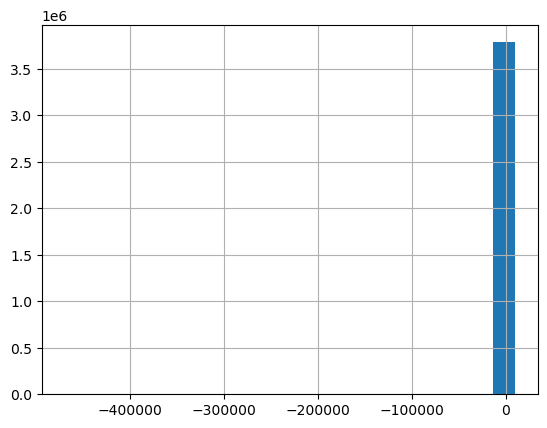

In [450]:
fig, ax = plt.subplots()
df[feature].loc[df[feature] < 1e4].hist(bins=20, ax=ax)
ax.set_xscale('linear')

<Axes: xlabel='Alternative Delinquency Resolution'>

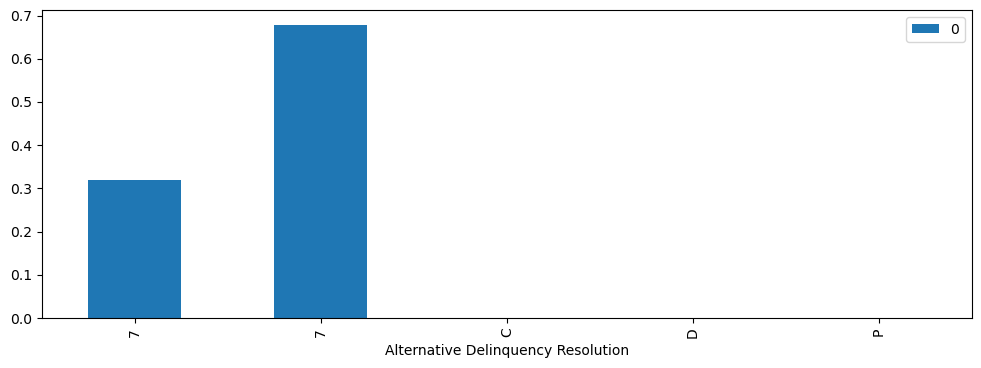

In [473]:
fig, ax = plt.subplots(figsize=(12, 4))
(df.groupby(feature).size().to_frame()/df.shape[0]).plot(kind='bar', ax=ax)

## Missing values

In [519]:
def missing(df):
    missing_values = df.isna().sum()/len(df)
    missing_values = pd.DataFrame(missing_values.loc[missing_values != 0], 
                                  columns=['freq'])#.reset_index(names='Field Name')#.sort_values(by='freq')
    return missing_values

def plot_missing(df_missing, ax=None):
    df_missing.plot(kind='barh', ax=ax)

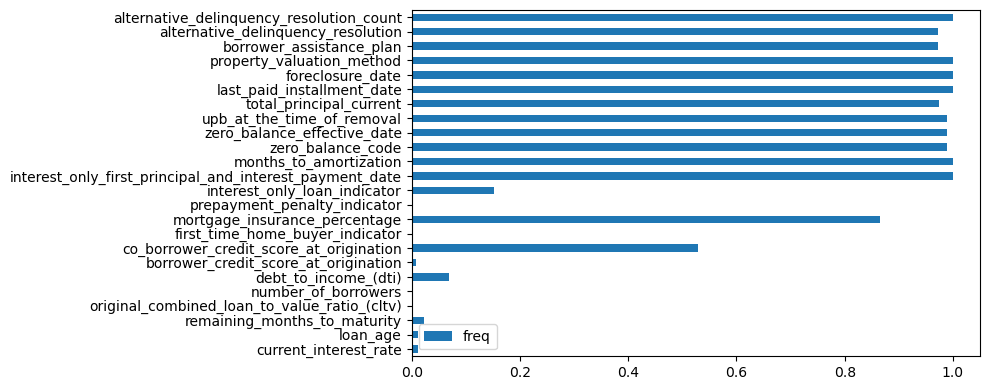

In [520]:
fig, ax = plt.subplots(figsize=(10, 4))

df_missing = missing(df)
plot_missing(df_missing, ax=ax)

plt.tight_layout()
plt.show()

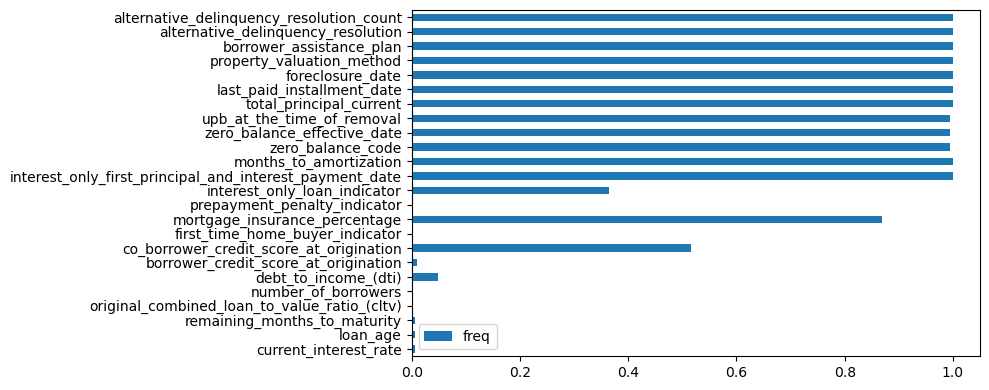

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

dfagg05_missing = missing(dfagg05)
plot_missing(dfagg05_missing, ax=ax)

plt.tight_layout()
plt.show()

## Agreggate years

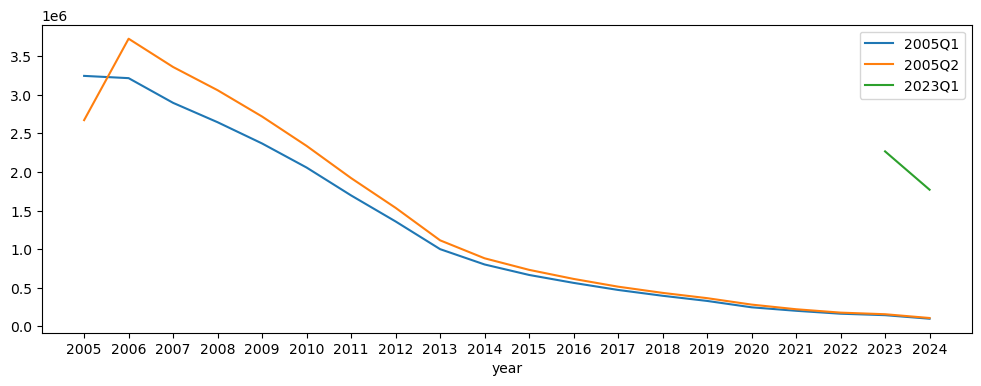

In [785]:
fig, ax = plt.subplots(figsize=(12, 4))

df05.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q1')
df05Q2.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2005Q2')
df23Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

### Split years


In [70]:
def split_years(save_path: str, df: pd.DataFrame):
    ''' Split years and save each year in a separate csv file.'''
    for y in df.year.unique():
        print(f'Saving {y}')
        df_year = df.loc[df.year == y]  # Filter year
        # Save path
        file_path = f'{save_path}agg_{y}.csv'
        meta_path = f'{save_path}agg_{y}_meta.csv'
        
        # Check if file exists before reading
        if os.path.exists(file_path):
            df_agg = pd.read_csv(file_path)  # Load existing data
            df_agg = pd.concat([df_agg, df_year], ignore_index=True)  # Append new data
        else:
            df_agg = df_year  # Start a new DataFrame if the file doesn’t exist

        # Save the updated DataFrame
        df_agg.sort_values(by=['time', 'loan_identifier'])
        df_agg.to_csv(file_path, index=False)
        # Meta data
        df_meta = pd.DataFrame(df_agg['acquisition'].unique(), columns=['acquisition'])
        df_meta.to_csv(meta_path, index=False)


In [42]:
def aggregate_fanniemae(input_path: str, 
                        output_path: str, 
                        years: List[int], 
                        quarters: List[int], 
                        cols: pd.Series, 
                        selected_features: List[str]) -> None:
    for y in years:
        if quarters == 'all':
            quarters = [1, 2, 3, 4]
        for q in quarters:
            df = load_fanniemae_sf(input_path, Y=y, Q=q, cols=cols, selected_features=selected_features)
            acq = f'{y}Q{q}'
            df['acquisition'] = acq
            print(f'Splitting {acq}')
            split_years(output_path, df)

In [ ]:
YEAR_LIST = [2005]
QUARTER_LIST = [3]
AGG_PATH = DATA_PATH+'aggregate_years/'

In [ ]:
%%time
aggregate_fanniemae(DATA_PATH, AGG_PATH, YEAR_LIST, QUARTER_LIST, cols=GLOSSARY_COLS, selected_features=selected_fields)

Files to load: ['../datasets/FannieMae/2005Q3.csv']


/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_64193/4065276026.py:21: DtypeWarning: Columns (40,101,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f, sep='|', names=cols) for f in files], ignore_index=True)


Splitting 2005Q3
Saving 2005
Saving 2006
Saving 2007
Saving 2008
Saving 2009
Saving 2010
Saving 2011
Saving 2012
Saving 2013
Saving 2014
Saving 2015
Saving 2016
Saving 2017
Saving 2018
Saving 2019
Saving 2020
Saving 2021
Saving 2022
Saving 2023
Saving 2024
CPU times: user 16min 26s, sys: 2min 9s, total: 18min 36s
Wall time: 19min 19s


In [45]:
%%time
df2005_12 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 6.24 s, sys: 1.24 s, total: 7.49 s
Wall time: 7.51 s


In [57]:
%%time
df2005_123 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 8.79 s, sys: 2 s, total: 10.8 s
Wall time: 11 s


In [73]:
%%time
df2005_1234 = pd.read_csv(f'{AGG_PATH}agg_2005.csv')

CPU times: user 9.42 s, sys: 2.26 s, total: 11.7 s
Wall time: 11.9 s


In [51]:
%%time

df2006_12 = pd.read_csv(f'{AGG_PATH}agg_2006.csv')

CPU times: user 7.48 s, sys: 1.56 s, total: 9.04 s
Wall time: 9.13 s


In [78]:
%%time

df2006_1234 = pd.read_csv(f'{AGG_PATH}agg_2006.csv')

CPU times: user 18.1 s, sys: 6.85 s, total: 25 s
Wall time: 27.8 s


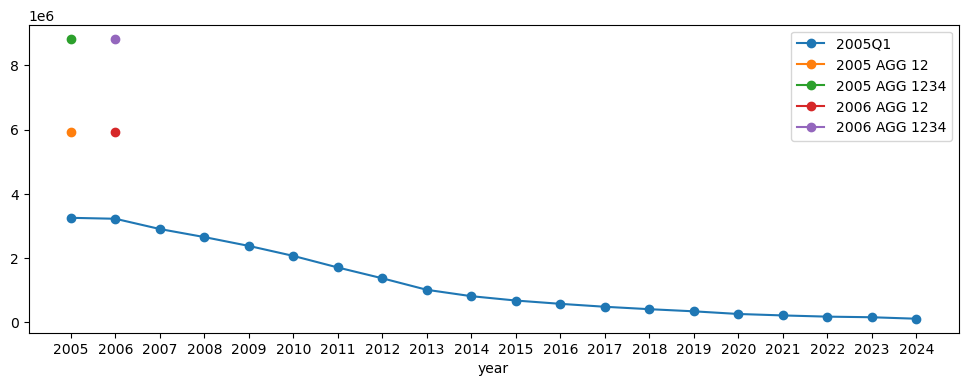

In [80]:
fig, ax = plt.subplots(figsize=(12, 4))

df05Q1.groupby('year')['loan_identifier'].size().plot(ax=ax, marker='o', label='2005Q1')
# df23.groupby('year')['loan_identifier'].size().plot(ax=ax, label='2023Q1')
ax.plot(2005, len(df2005_12), marker='o', label='2005 AGG 12')
ax.plot(2005, len(df2005_1234), marker='o', label='2005 AGG 1234')
ax.plot(2006, len(df2005_12), marker='o', label='2006 AGG 12')
ax.plot(2006, len(df2005_1234), marker='o', label='2006 AGG 1234')

ax.legend()
ax.set_xticks(np.arange(2005, 2025))

plt.show()

## Definition of Default

- Two variable are used to define default: 'Zero Balance Code' and the delinquency status ('Current Loan Delinquency Status')
- Zero Balance Codes that are a default event: 3 (Short Sale), 9 (Deed-in-Lieu/REO Disposition), 15 (Non-Performing Note Sale)
- Delinquency status for default can be 3 months (> 90 days) or 6 months (> 180 days), etc.
- There is a small number of loans (64) with unknow delinquency status (XX) and with nan zero balance code. These loans are removed, their whole history.
- All the other XX delinquency status end with a zero balance code. For those entries, the XX delinquency status is replaced by the previous delinquency status plus 1.
- The definition of default is then a zero balance code equal to 3, 9, or 15, or a delinquency equal or greater to 3 (or 6) months.

### Zero Balance Code

There is a considerable number of entries with nan zb code. This is fine because it just means these loans are still performing. The only problem is when the zb code is nan and the delinquency status is unknown (XX). There are only 64 loans with nan zb code and XX delinquency status. These loans can be removed.

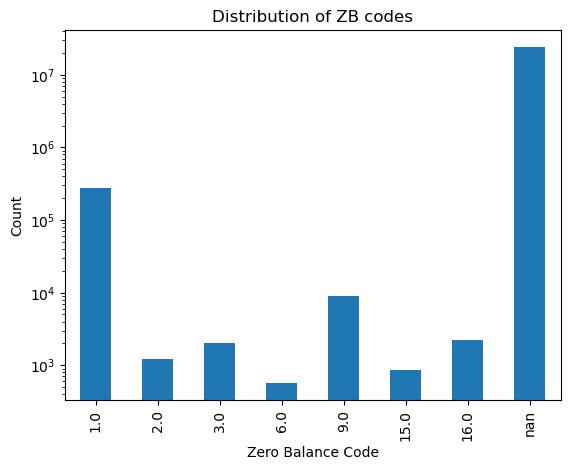

In [316]:
fig, ax = plt.subplots()
df.zero_balance_code.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Zero Balance Code')
ax.set_title('Distribution of ZB codes')
plt.show()

In [324]:
def compute_XX_zbNaN(df):
    df_entries_XX_zbNaN = df.loc[(df.zero_balance_code.isna()) & (df.delinquency_status == 'XX')]
    loan_ids = df_entries_XX_zbNaN['loan_identifier'].unique()
    num_entries_XX_zbNaN = len(df_entries_XX_zbNaN)
    num_loans_XX_zbNaN = df_entries_XX_zbNaN['loan_identifier'].nunique()
    total_entries = len(df.loc[df['loan_identifier'].isin(loan_ids)])
    return num_entries_XX_zbNaN, num_loans_XX_zbNaN, total_entries

In [330]:
num_entries_XX_zbNaN, num_loans_XX_zbNaN, total_num_entries = compute_XX_zbNaN(df)
print(f'Number of entries with unknown delinquency status and nan zero balance code: {num_entries_XX_zbNaN}.')
print(f'Number of loans with unknown delinquency status and nan zero balance code: {num_loans_XX_zbNaN}.')
print(f'Total number of entries related these loans: {total_num_entries}')
print(f'Percentage with respect to the whole dataset: {100*total_num_entries/len(df):.2f}%')

Number of entries with unknown delinquency status and nan zero balance code: 69.
Number of loans with unknown delinquency status and nan zero balance code: 64.
Total number of entries related these loans: 8219
Percentage with respect to the whole dataset: 0.03%


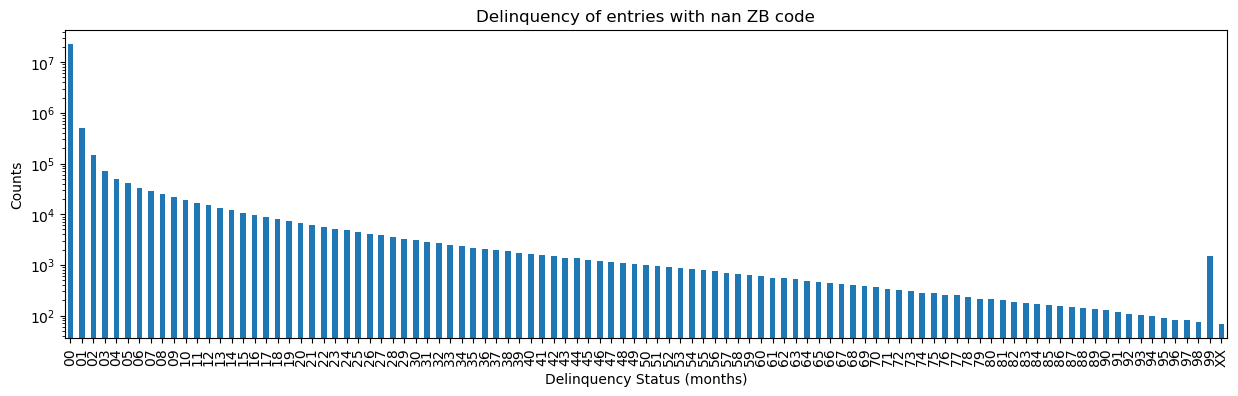

In [317]:
fig, ax = plt.subplots(figsize=(15, 4))
df.loc[df.zero_balance_code.isna()].delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)
ax.set_xlabel('Delinquency Status (months)')
ax.set_ylabel('Counts')
ax.set_title('Delinquency of entries with nan ZB code')
plt.show()

<font size="6"> Short Sale: ZB code = 3 </font>

In [153]:
df.loc[df.zero_balance_code == 3]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
00,1
06,1
09,1
10,2
13,1
19,2
25,1
31,1
73,1


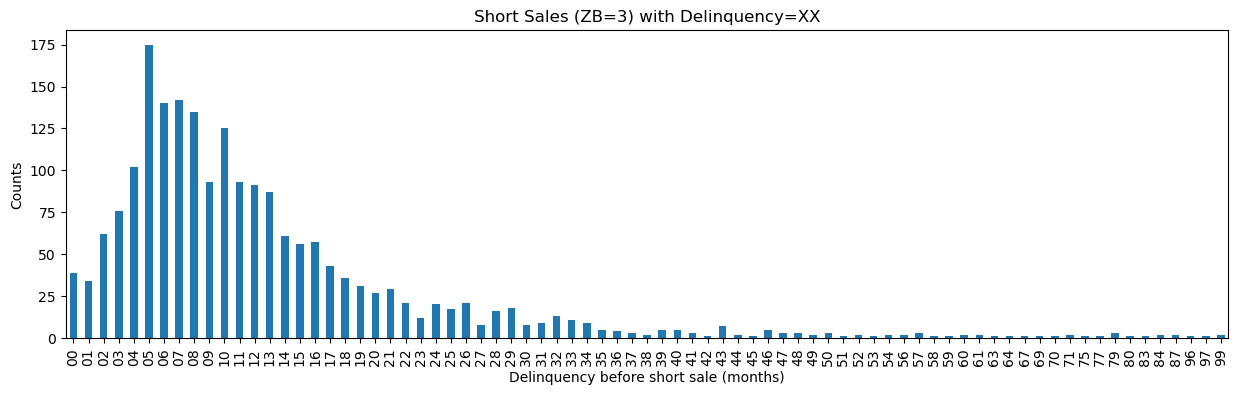

In [302]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb3_deliXX = df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb3_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before short sale (months)')
ax.set_title('Short Sales (ZB=3) with Delinquency=XX')

plt.show()

<font size="3"> Example 1: ZB code = 3, Delinquency = 0 </font>

In [62]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == '00')]

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
18179130,766994788392,2021-03-01,2021,R,5.875,5.875,46000.0,0.0,360,NaN,...,30634.77,0.0,32021.0,32021.0,7,NaN,N,7,7,NaN


In [81]:
df.loc[df.loan_identifier == 766994788392][['loan_identifier', 
                                            'time', 
                                            #'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
18178941,766994788392,2005-06-01,00,5.0,32.0,46000.0,0.00,NaN,NaN,NaN
18178942,766994788392,2005-07-01,00,6.0,32.0,46000.0,45218.24,NaN,NaN,NaN
18178943,766994788392,2005-08-01,00,7.0,32.0,46000.0,45170.47,NaN,NaN,NaN
18178944,766994788392,2005-09-01,00,8.0,32.0,46000.0,45122.47,NaN,NaN,NaN
18178945,766994788392,2005-10-01,00,9.0,32.0,46000.0,45074.23,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
18179126,766994788392,2020-11-01,00,190.0,32.0,46000.0,30988.80,NaN,NaN,116.86
18179127,766994788392,2020-12-01,00,191.0,32.0,46000.0,30871.37,NaN,NaN,117.43
18179128,766994788392,2021-01-01,00,192.0,32.0,46000.0,30753.36,NaN,NaN,118.01
18179129,766994788392,2021-02-01,00,193.0,32.0,46000.0,30634.77,NaN,NaN,118.59


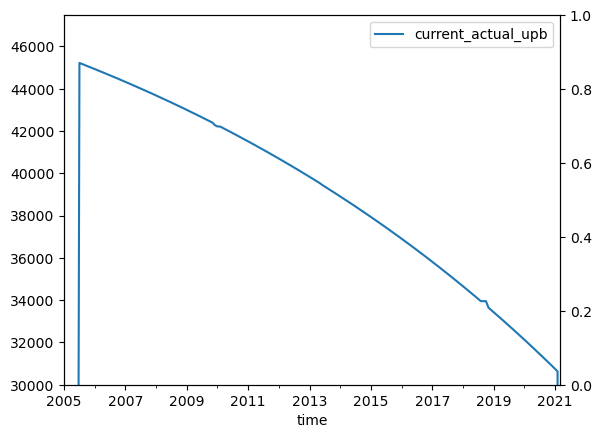

In [93]:
fig, ax = plt.subplots()
df.loc[df.loan_identifier == 766994788392].plot(x='time', y='current_actual_upb', ax = ax)
ax.set_ylim(bottom=3e4)

ax1 = ax.twinx()
# df.loc[df.loan_identifier == 766994788392].plot(x='time', y='delinquency_status', ax = ax1)

<font size="3"> Example 2: ZB code = 3, Delinquency = 73</font>

In [82]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == '73')]

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
3688320,234620717357,2024-01-01,2024,B,5.875,5.875,135000.0,0.0,360,NaN,...,99399.84,0.0,122017.0,12024.0,7,NaN,N,7,7.0,NaN


In [86]:
df.loc[df.loan_identifier == 234620717357][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
3688098,234620717357,2005-07-01,NaN,00,6.0,54.0,135000.0,0.00,NaN,NaN,NaN
3688099,234620717357,2005-08-01,NaN,00,7.0,54.0,135000.0,133998.80,NaN,NaN,NaN
3688100,234620717357,2005-09-01,NaN,00,8.0,54.0,135000.0,133855.55,NaN,NaN,NaN
3688101,234620717357,2005-10-01,NaN,00,9.0,54.0,135000.0,133711.59,NaN,NaN,NaN
3688102,234620717357,2005-11-01,NaN,00,10.0,54.0,135000.0,133566.93,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3688316,234620717357,2023-09-01,NaN,69,224.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688317,234620717357,2023-10-01,NaN,70,225.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688318,234620717357,2023-11-01,NaN,71,226.0,54.0,135000.0,99399.84,NaN,NaN,0.0
3688319,234620717357,2023-12-01,NaN,72,227.0,54.0,135000.0,99399.84,NaN,NaN,0.0


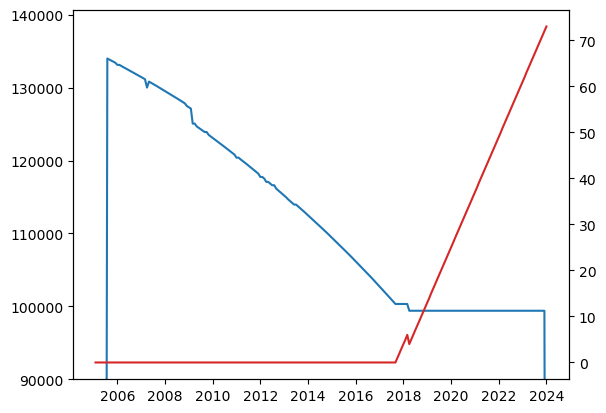

In [106]:
fig, ax = plt.subplots()

x=df.loc[df.loan_identifier == 234620717357]['time']
y=df.loc[df.loan_identifier == 234620717357]['current_actual_upb']
y1=df.loc[df.loan_identifier == 234620717357]['delinquency_status'].astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=9e4)

plt.show()

<font size="3"> Example 3: ZB code = 3, Delinquency = XX </font>

In [126]:
id_zb3_deliXX = df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb3_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).tail(2)

,loan_identifier,time,zero_balance_code,delinquency_status,original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal
8994,100312772807,2016-12-01,NaN,16,72000.0,58001.92,NaN,NaN
8995,100312772807,2017-01-01,3.0,XX,72000.0,0.00,12017.0,58001.92
19681,100706980869,2011-12-01,NaN,08,135000.0,150272.48,NaN,NaN
19682,100706980869,2012-01-01,3.0,XX,135000.0,0.00,12012.0,150272.48
23784,100838142997,2013-03-01,NaN,18,211000.0,190163.82,NaN,NaN
...,...,...,...,...,...,...,...,...
24527071,998709078914,2011-03-01,3.0,XX,50000.0,0.00,32011.0,41467.60
24538774,999126619769,2011-04-01,NaN,00,292000.0,238962.33,NaN,NaN
24538775,999126619769,2011-05-01,3.0,XX,292000.0,0.00,52011.0,238962.33
24539148,999154787202,2013-02-01,NaN,33,228000.0,210577.64,NaN,NaN


In [109]:
df.loc[(df.zero_balance_code == 3) & (df.delinquency_status == 'XX')][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']]\
.groupby('loan_identifier', as_index=False).last()

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
0,100312772807,2017-01-01,3.0,XX,NaN,33.0,72000.0,0.0,12017.0,58001.92,NaN
1,100706980869,2012-01-01,3.0,XX,NaN,NaN,135000.0,0.0,12012.0,150272.48,NaN
2,100838142997,2013-04-01,3.0,XX,NaN,28.0,211000.0,0.0,42013.0,190163.82,NaN
3,100861611900,2013-03-01,3.0,XX,NaN,41.0,128000.0,0.0,32013.0,77959.91,NaN
4,100957210024,2012-02-01,3.0,XX,NaN,20.0,114000.0,0.0,22012.0,100591.96,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2005,998067700189,2013-10-01,3.0,XX,NaN,41.0,261000.0,0.0,102013.0,231307.14,NaN
2006,998472303113,2013-11-01,3.0,XX,NaN,51.0,144000.0,0.0,112013.0,127219.42,NaN
2007,998709078914,2011-03-01,3.0,XX,NaN,40.0,50000.0,0.0,32011.0,41467.60,NaN
2008,999126619769,2011-05-01,3.0,XX,NaN,6.0,292000.0,0.0,52011.0,238962.33,NaN


In [110]:
df.loc[df.loan_identifier == 100312772807][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'loan_age', 
                                            'debt_to_income_(dti)', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal', 'total_principal_current']].iloc[5:]

,loan_identifier,time,zero_balance_code,delinquency_status,loan_age,debt_to_income_(dti),original_upb,current_actual_upb,zero_balance_effective_date,upb_at_the_time_of_removal,total_principal_current
8857,100312772807,2005-07-01,NaN,00,6.0,33.0,72000.0,0.00,NaN,NaN,NaN
8858,100312772807,2005-08-01,NaN,00,7.0,33.0,72000.0,71019.48,NaN,NaN,NaN
8859,100312772807,2005-09-01,NaN,00,8.0,33.0,72000.0,70942.23,NaN,NaN,NaN
8860,100312772807,2005-10-01,NaN,00,9.0,33.0,72000.0,70864.18,NaN,NaN,NaN
8861,100312772807,2005-11-01,NaN,00,10.0,33.0,72000.0,70786.19,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8991,100312772807,2016-09-01,NaN,13,140.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8992,100312772807,2016-10-01,NaN,14,141.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8993,100312772807,2016-11-01,NaN,15,142.0,33.0,72000.0,58001.92,NaN,NaN,NaN
8994,100312772807,2016-12-01,NaN,16,143.0,33.0,72000.0,58001.92,NaN,NaN,NaN


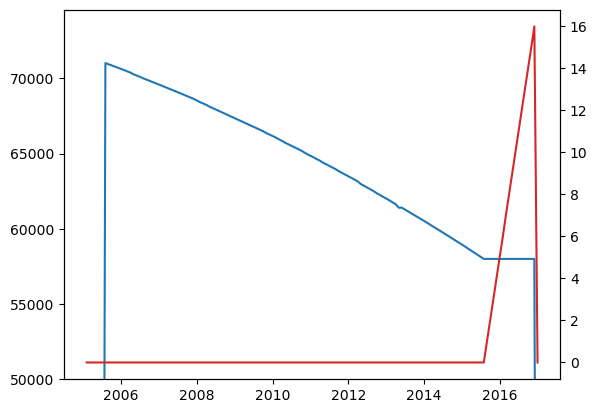

In [114]:
fig, ax = plt.subplots()

loan_id = 100312772807
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

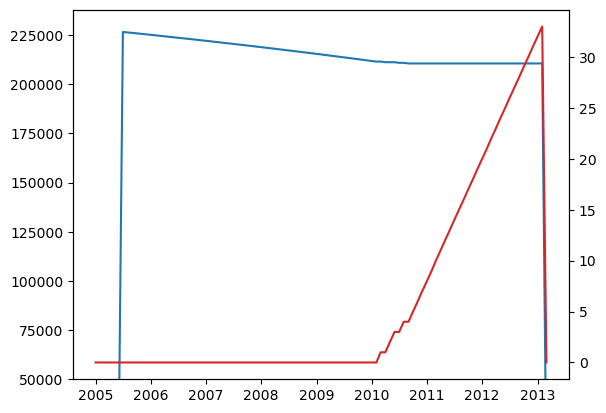

In [115]:
fig, ax = plt.subplots()

loan_id = 999154787202
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

<font size="6"> Deed-in-Lieu/REO disposition: ZB code = 9 </font>

In [151]:
df.loc[df.zero_balance_code == 9]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
06,2
07,6
08,1
09,1
10,2
11,2
12,1
13,2
14,3


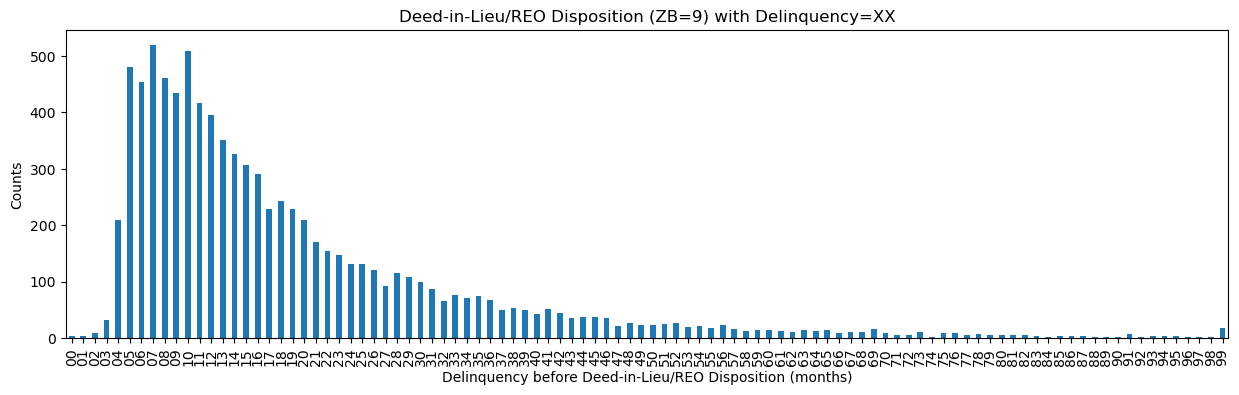

In [185]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb9_deliXX = df.loc[(df.zero_balance_code == 9) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb9_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before Deed-in-Lieu/REO Disposition (months)')
ax.set_title('Deed-in-Lieu/REO Disposition (ZB=9) with Delinquency=XX')

plt.show()

<font size="6"> Non-Performing Note Sale: ZB code = 15 </font>

In [180]:
df.loc[df.zero_balance_code == 15]['delinquency_status'].value_counts(dropna=False).sort_index().to_frame()

,count
delinquency_status,
00,181
XX,677


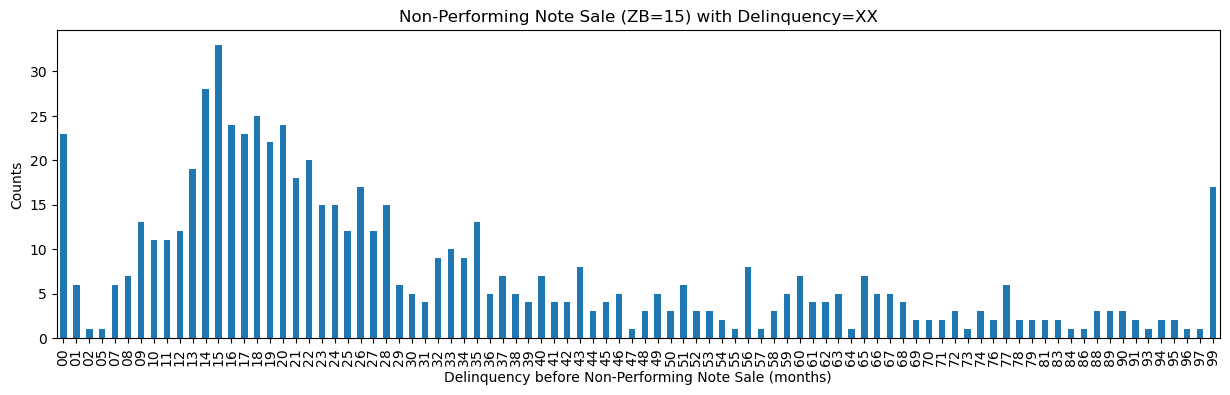

In [182]:
fig, ax= plt.subplots(figsize=(15, 4))
id_zb15_deliXX = df.loc[(df.zero_balance_code == 15) & (df.delinquency_status == 'XX')]['loan_identifier']
df.loc[df.loan_identifier.isin(id_zb15_deliXX)][['loan_identifier', 
                                            'time', 
                                            'zero_balance_code',  
                                            'delinquency_status', 
                                            'original_upb', 
                                            'current_actual_upb','zero_balance_effective_date', 'upb_at_the_time_of_removal']]\
.groupby('loan_identifier', as_index=False).nth(-2)['delinquency_status'].value_counts(dropna=False).sort_index().plot(kind='bar', ax=ax)
ax.set_ylabel('Counts')
ax.set_xlabel('Delinquency before Non-Performing Note Sale (months)')
ax.set_title('Non-Performing Note Sale (ZB=15) with Delinquency=XX')

plt.show()

<font size=6> REMINDER: make plots of zb code time-series </font>

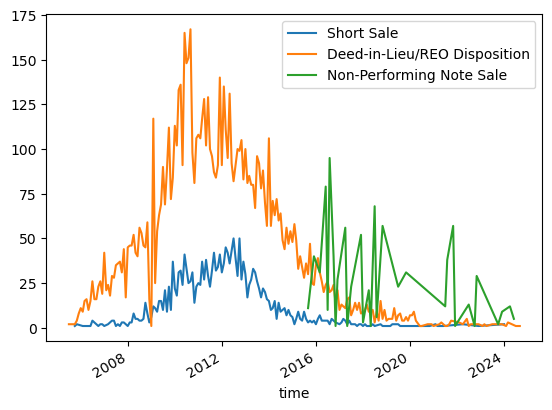

In [659]:
fig, ax = plt.subplots()

df.loc[df.zero_balance_code == 3].groupby('time').size().plot(ax=ax, label='Short Sale')
df.loc[df.zero_balance_code == 9].groupby('time').size().plot(ax=ax, label='Deed-in-Lieu/REO Disposition')
df.loc[df.zero_balance_code == 15].groupby('time').size().plot(ax=ax, label='Non-Performing Note Sale')
# df.loc[df.zero_balance_code.isin([3, 9, 15])].groupby('time').size().plot(ax=ax, label='Default ZB codes', color='grey')

ax.legend()

plt.show()

### Delinquency Status

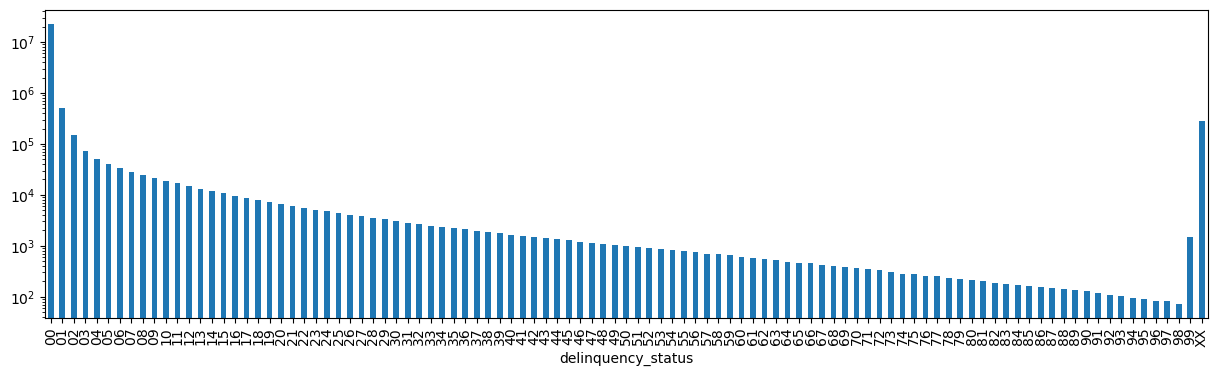

In [331]:
fig, ax = plt.subplots(figsize=(15, 4))

df.delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)

plt.show()

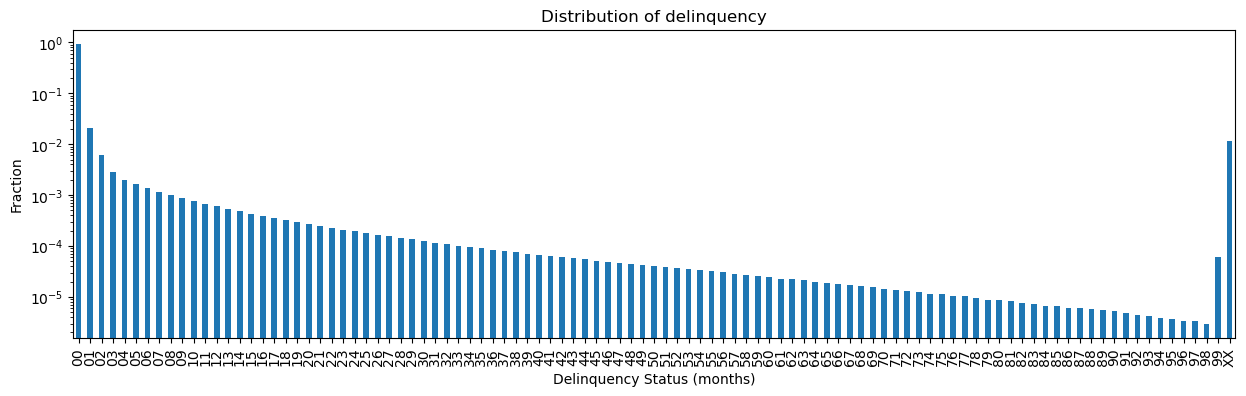

In [337]:
fig, ax = plt.subplots(figsize=(15, 4))

(df.delinquency_status.value_counts(dropna=False).sort_index()/len(df)).plot(kind='bar', logy=True, ax=ax)
ax.set_xlabel('Delinquency Status (months)')
ax.set_ylabel('Fraction')
ax.set_title('Distribution of delinquency')

plt.show()

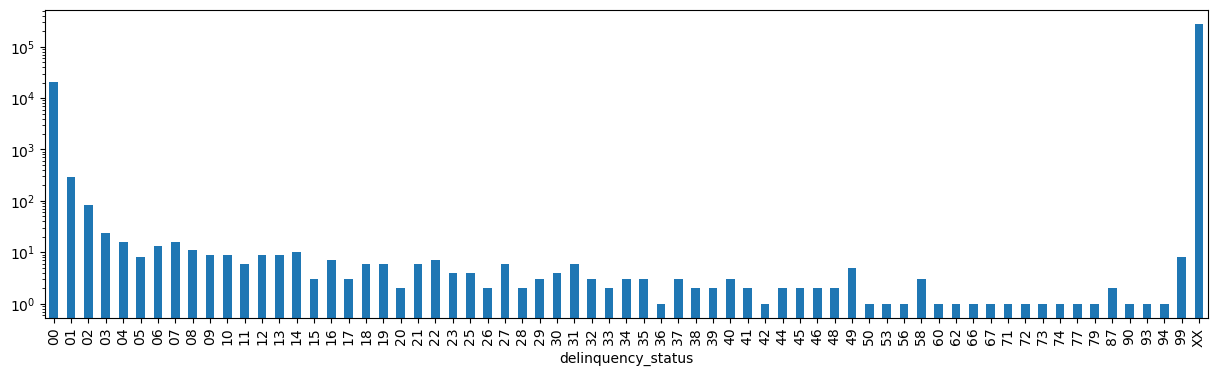

In [246]:
fig, ax = plt.subplots(figsize=(15, 4))

df.groupby('loan_identifier', as_index=False).last().delinquency_status.value_counts(dropna=False).sort_index().plot(kind='bar', logy=True, ax=ax)

plt.show()

In [226]:
df.loc[(df.delinquency_status == 'XX')].zero_balance_code.value_counts(dropna=False).sort_index()

zero_balance_code
1.0     268202
2.0       1139
3.0       2010
6.0        569
9.0       8804
15.0       677
16.0      1193
NaN         69
Name: count, dtype: int64

<font size=5> Delinquency status unknown (XX) and no zero balance code (nan) </font>

In [273]:
id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (~df.zero_balance_code.isin([1, 2, 3, 6, 9, 15, 16]))].loan_identifier.unique()

dfA = df.loc[df.loan_identifier.isin(id_zbNaN_deliXX)].groupby('loan_identifier', as_index=False).last()[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]#.zero_balance_code.value_counts(dropna=False).sort_index()
#.groupby(['delinquency_status', 'zero_balance_code']).size()
dfA

,loan_identifier,time,delinquency_status,zero_balance_code
0,101682024854,2017-07-01,XX,2.0
1,104374485722,2021-11-01,00,15.0
2,114050185852,2020-02-01,XX,9.0
3,122041729645,2017-10-01,XX,2.0
4,123486630181,2022-11-01,00,1.0
...,...,...,...,...
59,950397550669,2018-10-01,XX,2.0
60,955591826388,2020-11-01,00,16.0
61,964477905311,2018-10-01,XX,1.0
62,974515781580,2021-03-01,00,1.0


In [257]:
dfA.delinquency_status.value_counts(dropna=False).sort_index()

delinquency_status
00     8
58     1
79     1
99     2
XX    52
Name: count, dtype: int64

In [264]:
dfA.zero_balance_code.value_counts(dropna=False).sort_index()

zero_balance_code
1.0     11
2.0     16
6.0      1
9.0     29
15.0     3
16.0     3
NaN      1
Name: count, dtype: int64

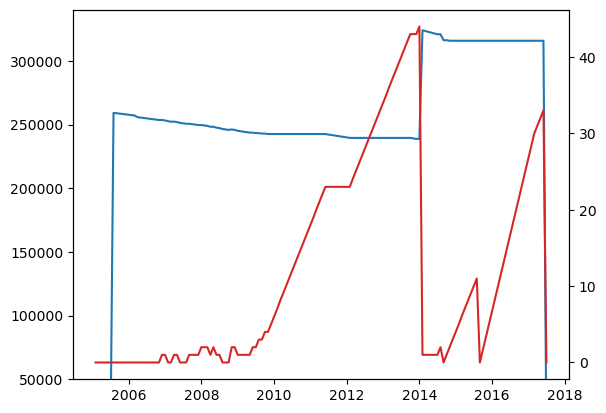

In [203]:
fig, ax = plt.subplots()

loan_id = 101682024854
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

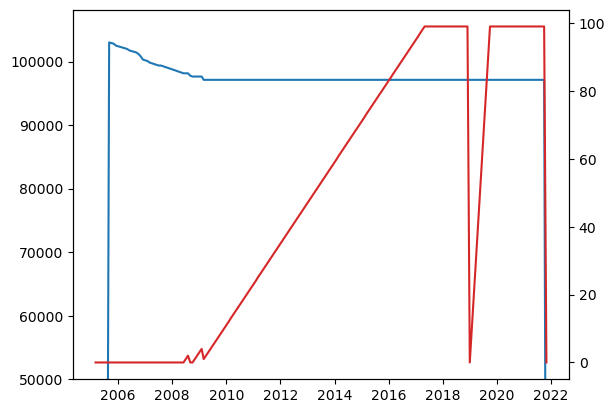

In [209]:
fig, ax = plt.subplots()

loan_id = 104374485722
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

## Handle XX

<font size=5> Conclusion: Remove loans with delinquency status unknown (XX) and no zero balance code (nan) </font>

In [637]:
%%time
# This is included in the prepocessing

# Remove loans with delinquency status unknown (XX) and no zero balance code (nan)
id_zbNaN_deliXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].loan_identifier.unique()
df.drop(df.loc[df['loan_identifier'].isin(id_zbNaN_deliXX)].index, inplace=True)

CPU times: user 2.75 s, sys: 912 ms, total: 3.67 s
Wall time: 3.75 s


<font size=5> Replace 'XX' with previous delinquency status + 1 </font>

In [638]:
%%time
# This is included in the prepocessing

# Replace 'XX' with previous delinquency status + 1
df = replaceXX(df)

CPU times: user 17.7 s, sys: 2.17 s, total: 19.9 s
Wall time: 20.3 s


In [370]:
# Sample DataFrame
df = pd.DataFrame({
    'time':[1, 2, 3, 1, 2, 3, 1],
    'loan_id': [1, 1, 1, 2, 2, 2, 3],
    'delinquency_status': ['0', '1', 'XX', '2', '3', 'XX', 'XX']
})

# display(df)

# Convert 'XX' to NaN (to use ffill)
df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
print('Step 1')
display(df)

# Vectorized forward fill within each loan_id group
mask = df['delinquency_status'].isna()
df.sort_values(['loan_id', 'time'], inplace=True)  # Ensure correct order per loan_id
df['delinquency_status'] = df.groupby('loan_id')['delinquency_status'].ffill().fillna(0)
print('Step 2')
display(df)

# Increment the 'XX' (previously NaN) values by 1
df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
print('Step 3')
display(df)

Step 1


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,NaN
3,1,2,2.0
4,2,2,3.0
5,3,2,NaN
6,1,3,NaN


Step 2


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,1.0
3,1,2,2.0
4,2,2,3.0
5,3,2,3.0
6,1,3,0.0


Step 3


,time,loan_id,delinquency_status
0,1,1,0.0
1,2,1,1.0
2,3,1,2.0
3,1,2,2.0
4,2,2,3.0
5,3,2,4.0
6,1,3,1.0


In [556]:
def replaceXX(df):
    
    # Convert 'XX' to NaN (to use ffill)
    df['delinquency_status'] = pd.to_numeric(df['delinquency_status'], errors='coerce')
    
    # Vectorized forward fill within each loan_id group
    mask = df['delinquency_status'].isna()
    df.sort_values(['loan_identifier', 'time'], inplace=True)  # Ensure correct order per loan_id
    df['delinquency_status'] = df.groupby('loan_identifier')['delinquency_status'].ffill().fillna(0)
    
    # Increment the 'XX' (previously NaN) values by 1
    df.loc[mask, 'delinquency_status'] = df.loc[mask, 'delinquency_status']+1
    df['delinquency_status'] = df['delinquency_status'].astype(int)
    df.sort_values('time', inplace=True) # ----------> Maybe remove this

    return df
    

In [557]:
# Sample DataFrame
df_test = pd.DataFrame({
    'time':[1, 3, 2, 1, 2, 3, 1],
    'loan_identifier': [1, 1, 1, 2, 2, 2, 3],
    'delinquency_status': ['0', 'XX', '1', '2', '3', 'XX', 'XX']
})
display(df_test)
replaceXX(df_test)
display(df_test)

,time,loan_identifier,delinquency_status
0,1,1,0
1,3,1,XX
2,2,1,1
3,1,2,2
4,2,2,3
5,3,2,XX
6,1,3,XX


,time,loan_identifier,delinquency_status
0,1,1,0
3,1,2,2
6,1,3,1
2,2,1,1
4,2,2,3
1,3,1,2
5,3,2,4


In [558]:
xxids = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code == 15)]['loan_identifier'].unique()
dfA = df.loc[df.loan_identifier.isin(xxids)].copy()
dfA

,loan_identifier,time,year,channel,original_interest_rate,current_interest_rate,original_upb,current_actual_upb,original_loan_term,loan_age,...,upb_at_the_time_of_removal,total_principal_current,last_paid_installment_date,foreclosure_date,special_eligibility_program,property_valuation_method,high_balance_loan_indicator,borrower_assistance_plan,alternative_delinquency_resolution,alternative_delinquency_resolution_count
5926,100213557668,2005-01-01,2005,B,5.375,5.375,122000.0,0.00,180,0.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5927,100213557668,2005-02-01,2005,B,5.375,5.375,122000.0,0.00,180,1.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5928,100213557668,2005-03-01,2005,B,5.375,5.375,122000.0,0.00,180,2.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5929,100213557668,2005-04-01,2005,B,5.375,5.375,122000.0,0.00,180,3.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
5930,100213557668,2005-05-01,2005,B,5.375,5.375,122000.0,0.00,180,4.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24540574,999220746282,2016-04-01,2016,B,5.500,4.500,176000.0,172945.42,360,134.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540575,999220746282,2016-05-01,2016,B,5.500,4.500,176000.0,172945.42,360,135.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540576,999220746282,2016-06-01,2016,B,5.500,4.500,176000.0,172945.42,360,136.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN
24540577,999220746282,2016-07-01,2016,B,5.500,4.500,176000.0,172945.42,360,137.0,...,NaN,NaN,NaN,NaN,7,NaN,N,NaN,NaN,NaN


In [563]:
dfB = dfA.groupby('loan_identifier').nth(-2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]
dfC = dfA.loc[dfA.loan_identifier.isin(dfB.loc[dfB.delinquency_status.isin(['99', '00'])].loan_identifier.unique()[:4])].copy()

In [564]:
dfC.groupby('loan_identifier').tail(2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]#.sort_values(by=['loan_identifier', 'time'])

,loan_identifier,time,delinquency_status,zero_balance_code
213995,107719526284,2016-09-01,99,NaN
213996,107719526284,2016-10-01,XX,15.0
1645438,159693686121,2017-06-01,00,NaN
1645439,159693686121,2017-07-01,XX,15.0
2131932,177375143326,2019-10-01,00,NaN
2131933,177375143326,2019-11-01,XX,15.0
2158114,178439554429,2017-03-01,00,NaN
2158115,178439554429,2017-04-01,XX,15.0


In [562]:
dfC.groupby('loan_identifier').tail(2)[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']].sort_values(by=['loan_identifier', 'time'])

,loan_identifier,time,delinquency_status,zero_balance_code
213995,107719526284,2016-09-01,99,NaN
213996,107719526284,2016-10-01,100,15.0
1645438,159693686121,2017-06-01,0,NaN
1645439,159693686121,2017-07-01,1,15.0
2131932,177375143326,2019-10-01,0,NaN
2131933,177375143326,2019-11-01,1,15.0
2158114,178439554429,2017-03-01,0,NaN
2158115,178439554429,2017-04-01,1,15.0


In [561]:
dfC = replaceXX(dfC)

In [546]:
numXX = df.loc[(df.delinquency_status == 'XX') & (df.zero_balance_code.isna())].groupby('loan_identifier').size()

In [511]:
numXX = df.loc[(df.delinquency_status == 'XX')].groupby('loan_identifier').size()

In [551]:
numXX

loan_identifier
101682024854    1
104374485722    1
114050185852    1
122041729645    1
123486630181    1
               ..
950397550669    1
955591826388    1
964477905311    1
974515781580    1
999747352775    1
Length: 64, dtype: int64

In [533]:
len(id_zbNaN_deliXX)

64

In [549]:
len(np.isin(id_zbNaN_deliXX, numXX[numXX > 1].index))

64

In [550]:
numXX[numXX > 1].index

Index([124439410821, 167586058303, 498269724083, 548300249397, 763768185879], dtype='int64', name='loan_identifier')

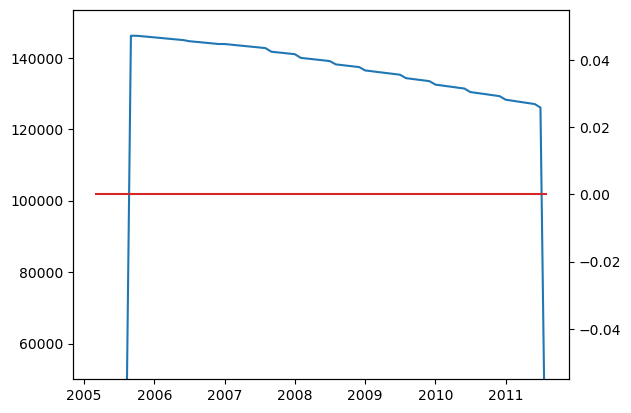

In [555]:
fig, ax = plt.subplots()

loan_id = 763768185879
x=df.loc[df.loan_identifier == loan_id]['time']
y=df.loc[df.loan_identifier == loan_id]['current_actual_upb']
y1=df.loc[df.loan_identifier == loan_id]['delinquency_status'].replace('XX', 0).astype(int)

ax.plot(x, y)
ax1 = ax.twinx()
ax1.plot(x, y1, color='tab:red')

ax.set_ylim(bottom=5e4)

plt.show()

<Axes: xlabel='delinquency_status'>

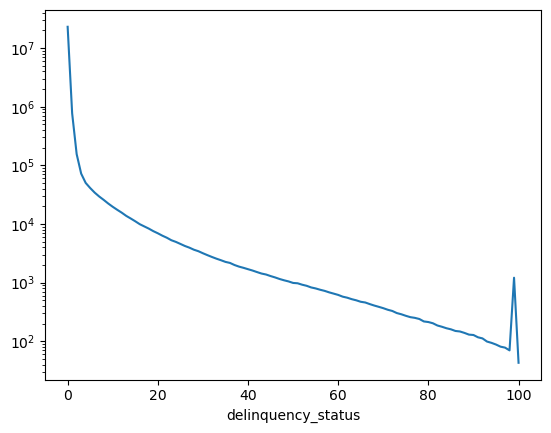

In [571]:
df.delinquency_status.value_counts(dropna=False).sort_index().plot(logy=True)

In [444]:
def plot_delinquency(df, threshold=None, ax=None, label=None):
    df.loc[df.delinquency_status >= threshold].groupby('time').size().plot(ax=ax, label=label)

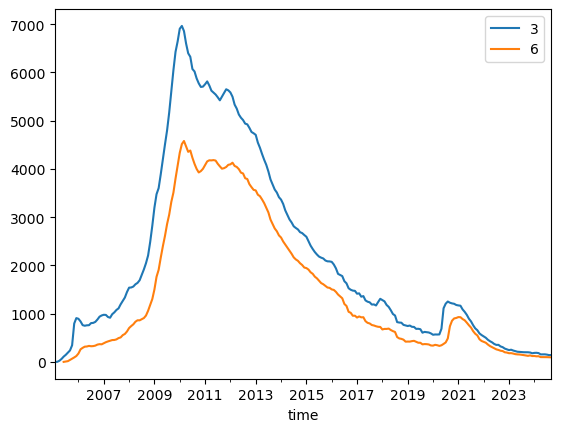

In [581]:
fig, ax = plt.subplots()

plot_delinquency(df, threshold=3, ax=ax, label='3')
plot_delinquency(df, threshold=6, ax=ax, label='6')
ax.legend()

plt.show()

In [600]:
len(df.loc[(df.delinquency_status >= 6) | (df.zero_balance_code.isin([3, 9, 15]))]) - len(df.loc[(df.delinquency_status >= 6)])

781

### Default

In [127]:
def define_default(df: pd.DataFrame, delinquency_threshold: int=None, pred_tw: int=None) -> pd.DataFrame:

    # Target default time window must be less then default threshold
    if pred_tw >= delinquency_threshold:
        raise ValueError('pred_tw must be < delinquency_threshold.')
    
    # Step 1: Identify the first month each loan defaults (delinquency_status >= 6)
    df['default_flag'] = ((df['delinquency_status'] >= delinquency_threshold) | (df['zero_balance_code'].isin([3, 9, 15])))

    # Step 2: Separate default from non-default loans
    default_loans = df.loc[df['default_flag'] == True]['loan_identifier'].unique()
    df_non_default_loans = df[~df['loan_identifier'].isin(default_loans)]
    df = df.loc[df['loan_identifier'].isin(default_loans)]

    # Step 3: Find the first default month per loan
    first_default_time = df[df['default_flag']].groupby('loan_identifier')['time'].min().rename('default_time')

    # Step 4: Merge this info back to the main dataframe
    df = df.merge(first_default_time, on='loan_identifier', how='left')
    df['default_time'] = df['default_time'].fillna(pd.NaT)

    # Step 5: Create an irreversible default flag (1 if loan has defaulted, 0 otherwise)
    df['default'] = (df['time'] >= df['default_time']).astype(int)

    # Step 6: Keep only records **before** or **at** the first default event
    df = df[df['time'] <= df['default_time']].copy()

    # Step 7: Create a target variable for PD (whether the loan will default in the next N months)
    df['pd_target'] = df.groupby('loan_identifier')['default_flag'].shift(-pred_tw).astype(float).ffill()
    df.loc[df['time'] >= df['default_time'], 'pd_target'] = 1 # Default before pred_tw
    df['pd_target'] = df['pd_target'].fillna(0).astype(int) # Not default before pred_tw

    # Step 8: Append non-default loans
    df = pd.concat([df, df_non_default_loans])
    df['default'] = df['default'].fillna(0)
    df['pd_target'] = df['pd_target'].fillna(0)

    df.drop(['default_flag', 'default_time'], axis=1, inplace=True)
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [14]:
%%time
# Default of the whole dataset
df = define_default(df, delinquency_threshold=6, pred_tw=6)

CPU times: user 11.7 s, sys: 10.2 s, total: 21.9 s
Wall time: 25.9 s


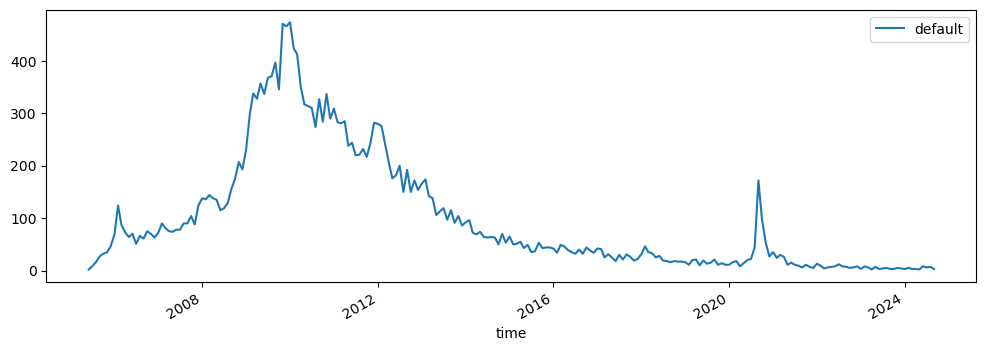

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))

df.loc[df.default==1].groupby('time')['default'].size().plot(ax=ax)

ax.legend()
# ax.set_xticks(dfD.time)

plt.show()

In [16]:
default_loans = df.loc[df.default == 1]['loan_identifier'].unique()

In [20]:
%%time
non_default_loans = list(set(list(df['loan_identifier'].unique())) - set(list(default_loans)))

CPU times: user 270 ms, sys: 14.4 ms, total: 284 ms
Wall time: 284 ms


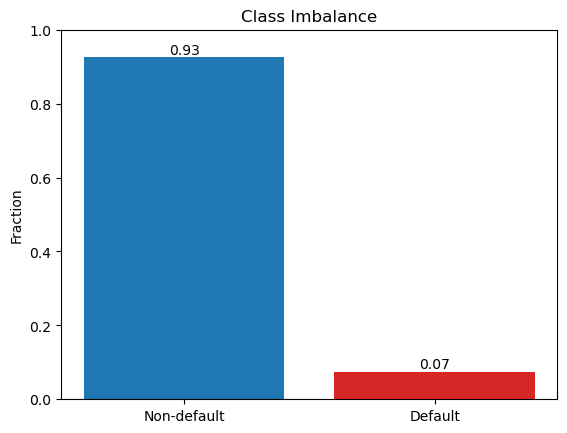

In [25]:
fig, ax = plt.subplots()

N = df.loan_identifier.nunique()
b = ax.bar(x=['Non-default', 'Default'], height=[len(non_default_loans)/N, len(default_loans)/N], color=['C0', 'C3'], label=[10, 20])
ax.bar_label(b, fmt='%.2f')

ax.set_ylim(top=1)
ax.set_title('Class Imbalance')
ax.set_ylabel('Fraction')

plt.show()

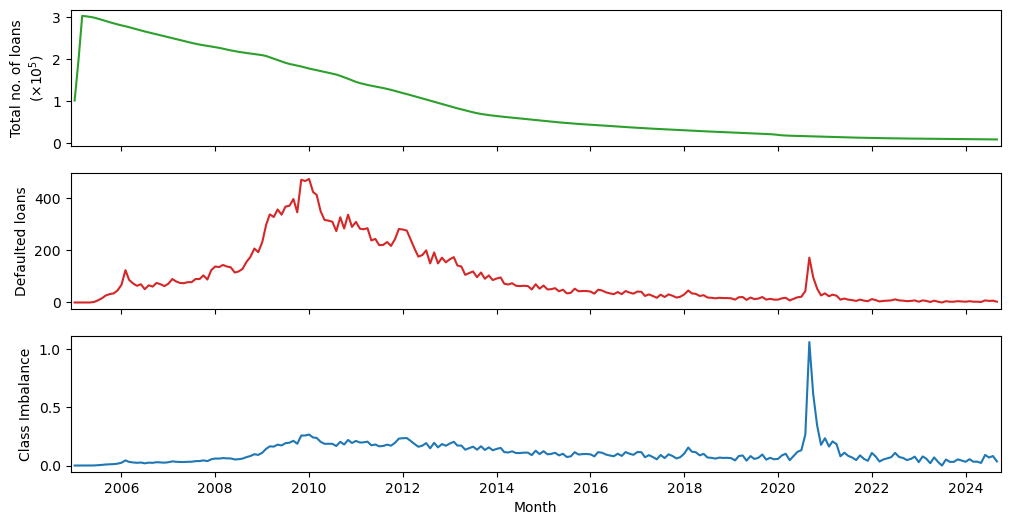

In [515]:
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# Total number of loans
y = df.groupby('time').size()
x = y.index
ax[0].plot(x, y/1e5, color='C2')


# Defult count
y = df.groupby('time')['default'].sum()
x = y.index
ax[1].plot(x, y, color='C3')

# Class imbalance
y = 100*df.groupby('time')['default'].sum()/df.groupby('time')['loan_identifier'].size()
x = y.index
ax[2].plot(x, y)

ax[0].set_ylabel('Total no. of loans\n'+r'($\times 10^{5}$)')
ax[0].set_xlabel('')

ax[1].set_ylabel('Defaulted loans')
ax[1].set_xlabel('')

ax[2].set_ylabel('Class Imbalance')
ax[2].set_xlabel('Month')
ax[2].set_xticks([i for i in x if (i.month == 1 and i.year % 2 ==0)], [f'{i.year}' for i in x if (i.month == 1 and i.year % 2 ==0)])
ax[2].set_xlim(left=x.min()-pd.Timedelta('30D'), right=x.max()+pd.Timedelta('30D'))

plt.show()

In [86]:
df.loc[df.default == 1][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
1406605,353449634239,2005-06-01,6,NaN,1.0,1.0
1418855,305909545974,2005-06-01,6,NaN,1.0,1.0
1585561,326769642533,2005-07-01,6,NaN,1.0,1.0
1601419,493418285478,2005-07-01,6,NaN,1.0,1.0
1602391,255736458219,2005-07-01,6,9.0,1.0,1.0
...,...,...,...,...,...,...
23507478,889369771615,2024-08-01,6,NaN,1.0,1.0
23507479,647107035110,2024-08-01,6,NaN,1.0,1.0
23514550,144726842502,2024-09-01,6,NaN,1.0,1.0
23515965,639844687273,2024-09-01,6,NaN,1.0,1.0


In [87]:
df.loc[df.loan_identifier == 353449634239][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
99347,353449634239,2005-01-01,1,NaN,0.0,0.0
262215,353449634239,2005-02-01,2,NaN,0.0,0.0
599215,353449634239,2005-03-01,3,NaN,0.0,0.0
765772,353449634239,2005-04-01,4,NaN,0.0,0.0
939153,353449634239,2005-05-01,5,NaN,0.0,0.0
1406605,353449634239,2005-06-01,6,NaN,1.0,1.0


In [209]:
dfA = df.loc[df.loan_identifier.isin(np.concat([default_loans[1:2], non_default_loans[:1]]))]\
[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]

In [236]:
default_loans[0]

np.int64(305909545974)

In [238]:
i=0

152


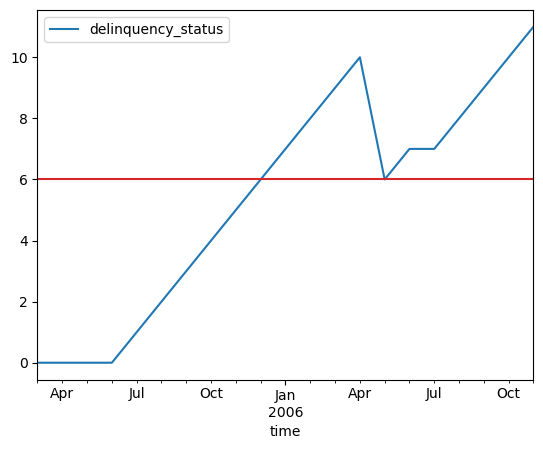

In [437]:
fig, ax = plt.subplots()

print(i)
df.loc[df.loan_identifier == default_loans[i]].plot(x='time', y='delinquency_status', ax=ax)
ax.axhline(y=6, color='tab:red')
i+=1

<Axes: xlabel='time'>

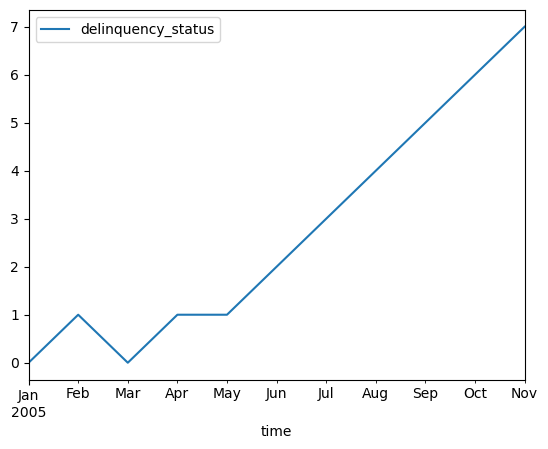

In [325]:
fig, ax = plt.subplots()

df.loc[df.loan_identifier == default_loans[70]].plot(x='time', y='delinquency_status', ax=ax)

<Axes: xlabel='time'>

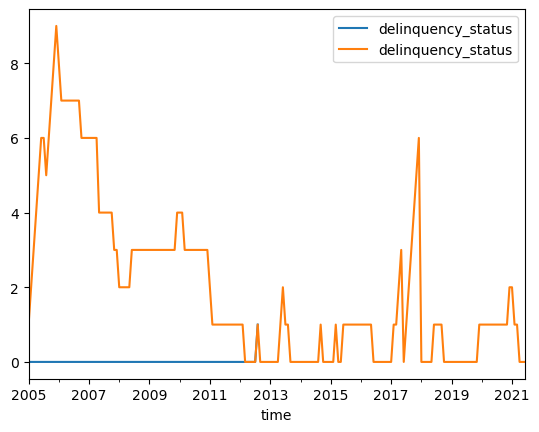

In [210]:
fig, ax = plt.subplots()
dfA.loc[df.loan_identifier.isin(non_default_loans)].plot(x='time', y='delinquency_status', ax=ax)
dfA.loc[df.loan_identifier.isin(default_loans)].plot(x='time', y='delinquency_status', ax=ax)

In [87]:
df.loc[df.loan_identifier == 353449634239][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
99347,353449634239,2005-01-01,1,NaN,0.0,0.0
262215,353449634239,2005-02-01,2,NaN,0.0,0.0
599215,353449634239,2005-03-01,3,NaN,0.0,0.0
765772,353449634239,2005-04-01,4,NaN,0.0,0.0
939153,353449634239,2005-05-01,5,NaN,0.0,0.0
1406605,353449634239,2005-06-01,6,NaN,1.0,1.0


In [413]:
dfA = df.loc[df.loan_identifier.isin(np.concat([default_loans[129:130], non_default_loans[:0]]))]\
[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]

In [98]:
dfA = df.loc[df.loan_identifier == 353449634239][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]

In [220]:
# dfA.drop(['default_flag', 'default_time', 'default', 'pd_target'], axis=1, inplace=True)

In [130]:
%%time
dfA = df.loc[df.loan_identifier == 353449634239][['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code']]
dfA = define_default(dfA, delinquency_threshold=6, pred_tw=3)
dfA.sort_values(['loan_identifier', 'time'])

CPU times: user 23.7 ms, sys: 3.8 ms, total: 27.5 ms
Wall time: 24.4 ms


,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
0,353449634239,2005-01-01,1,NaN,0.0,0.0
1,353449634239,2005-02-01,2,NaN,0.0,0.0
2,353449634239,2005-03-01,3,NaN,0.0,1.0
3,353449634239,2005-04-01,4,NaN,0.0,1.0
4,353449634239,2005-05-01,5,NaN,0.0,1.0
5,353449634239,2005-06-01,6,NaN,1.0,1.0


In [442]:
dfD[['loan_identifier', 'time', 'delinquency_status', 'zero_balance_code', 'default', 'pd_target']]

,loan_identifier,time,delinquency_status,zero_balance_code,default,target_default
0,370893910142,2005-01-01,0,NaN,0.0,0.0
1,936774229300,2005-01-01,0,NaN,0.0,0.0
2,936772694421,2005-01-01,0,NaN,0.0,0.0
3,680743668300,2005-01-01,0,NaN,0.0,0.0
4,164699402533,2005-01-01,0,NaN,0.0,0.0
...,...,...,...,...,...,...
23518775,416838688281,2024-09-01,0,NaN,0.0,0.0
23518776,539196144039,2024-09-01,0,NaN,0.0,0.0
23518777,159078194599,2024-09-01,0,NaN,0.0,0.0
23518778,843307312026,2024-09-01,0,NaN,0.0,0.0


In [83]:
pd.date_range(start=pd.Timestamp(2005, 1, 1), end=pd.Timestamp(2005, 4, 1), freq='MS')

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01'], dtype='datetime64[ns]', freq='MS')

In [1042]:
# Sample dataset (Replace with your actual data)
data = {
    'loan_identifier':    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5],
    'time':               [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 6, 1, 2, 3, 1, 2, 1, 2, 3],
    'delinquency_status': [2, 4, 6, 5, 3, 4, 5, 5, 6, 7, 8, 0, 1, 2, 5, 6, 7, 6, 0]  # Loan 1 never hits 6+, Loan 2 does
}

# data = {
#     'loan_identifier':    [4, 4, 5, 5, 5],
#     'time':               [1, 2, 1, 2, 3],
#     'delinquency_status': [6, 6, 7, 6, 7]  # Loan 1 never hits 6+, Loan 2 does
# }

# data = {
#     'loan_identifier':    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#     'time':               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'delinquency_status': [4, 6, 6, 0, 0, 0, 0, 0, 0, 0]  # Loan 1 never hits 6+, Loan 2 does
# }

df = pd.DataFrame(data)
df

,loan_identifier,time,delinquency_status
0,1,1,2
1,1,2,4
2,1,3,6
3,1,4,5
4,1,5,3
5,2,1,4
6,2,2,5
7,2,3,5
8,2,4,6
9,2,5,7


In [1044]:
df=preprocess_default(df, pred_tw=2)
df

,loan_identifier,time,delinquency_status,default,target_default
0,1,1,2,0,1
1,1,2,4,0,1
2,1,3,6,1,1
5,2,1,4,0,0
6,2,2,5,0,1
7,2,3,5,0,1
8,2,4,6,1,1
11,3,1,0,0,0
12,3,2,1,0,0
13,3,3,2,0,0


## Macroeconomic Variables

1. GDP
    - Source: FRED
    - Converted to YoY percentage change
    - Interpolated monthly
2. Unemployment Rate
    - Source: FRED
    - Already monthly percentage
    - Using the raw unemployment rate
3. Inflation
    -  Source: FRED
    - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
    - Converted to YoY percentage change
    - Already monthly
4. House Price Index
    - Source: FRED
    - All-Transactions House Price Index for the United States (USSTHPI)
    - Converted YoY percentage change
    - Interpolated monthly

<font size=3> Not implemented </font>

5. Credit Spreads
6. Unemployment by State
7. HPI by State

### GDP
- Convert to YoY percentage change
- Interpolate monthly

In [505]:
# GDP (YoY%, Monthly linear interpolation)
gdp = (web.DataReader('GDP', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max()+pd.DateOffset(months=1))\
       .pct_change(4) * 100).dropna()\
       .resample('MS').interpolate(method='linear')\
       .reset_index().rename(columns={'DATE':'time', 'GDP':'gdp'})
gdp

,time,gdp
0,2005-01-01,7.077140
1,2005-02-01,6.946700
2,2005-03-01,6.816260
3,2005-04-01,6.685820
4,2005-05-01,6.725435
...,...,...
233,2024-06-01,5.251997
234,2024-07-01,5.031580
235,2024-08-01,5.030279
236,2024-09-01,5.028978


<Axes: xlabel='time'>

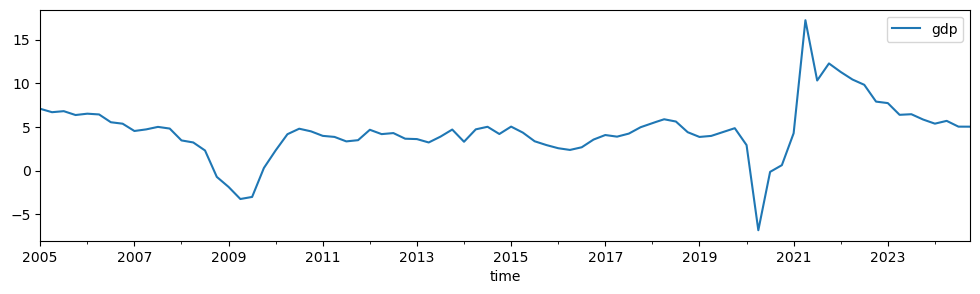

In [496]:
fig, ax = plt.subplots(figsize=(12, 3))
gdp.plot(x='time', y='gdp', ax=ax)

In [499]:
df[['loan_identifier', 'time']].tail().merge(gdp, on='time', how='left')

,loan_identifier,time,gdp
0,416838688281,2024-09-01,5.028978
1,539196144039,2024-09-01,5.028978
2,159078194599,2024-09-01,5.028978
3,843307312026,2024-09-01,5.028978
4,111848816525,2024-09-01,5.028978


### Unemployment Rate
- Already monthly percentage
- Using the raw unemployment rate

In [506]:
unrate = web.DataReader('UNRATE', 'fred', start=df['time'].min(), end=df['time'].max())\
         .reset_index().rename(columns={'DATE':'time', 'UNRATE':'unrate'})
unrate

,time,unrate
0,2005-01-01,5.3
1,2005-02-01,5.4
2,2005-03-01,5.2
3,2005-04-01,5.2
4,2005-05-01,5.1
...,...,...
232,2024-05-01,4.0
233,2024-06-01,4.1
234,2024-07-01,4.2
235,2024-08-01,4.2


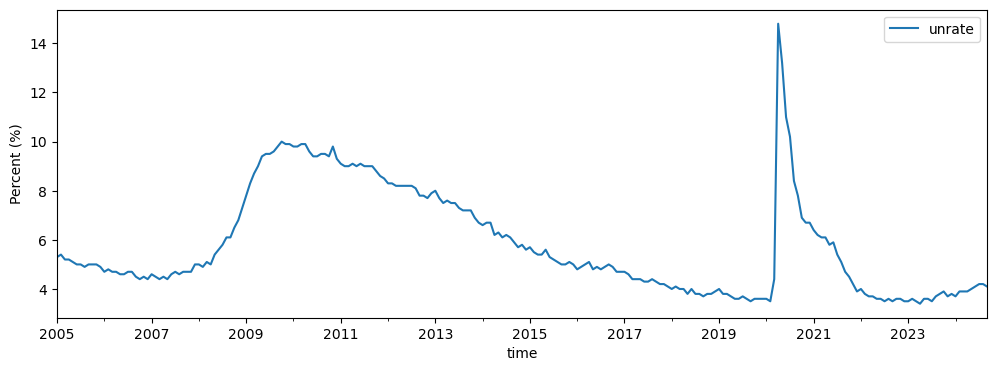

In [395]:
fig, ax = plt.subplots(figsize=(12, 4))

unrate.plot(x='time', y='unrate', ax=ax)
ax.set_ylabel('Percent (%)')

plt.show()

In [500]:
df[['loan_identifier', 'time']].tail().merge(unrate, on='time', how='left')

,loan_identifier,time,unrate
0,416838688281,2024-09-01,4.1
1,539196144039,2024-09-01,4.1
2,159078194599,2024-09-01,4.1
3,843307312026,2024-09-01,4.1
4,111848816525,2024-09-01,4.1


### Inflation (CPI)
- Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
- Converted to YoY percentage change
- Already monthly

In [508]:
# Inflation: Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
# Converted to YoY inflation percentage change
cpi = (web.DataReader('CPIAUCSL', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max())\
           .pct_change(12) * 100).dropna().reset_index().rename(columns={'DATE':'time', 'CPIAUCSL':'cpi'})
cpi

,time,cpi
0,2005-01-01,2.844874
1,2005-02-01,3.053026
2,2005-03-01,3.206841
3,2005-04-01,3.361793
4,2005-05-01,2.869288
...,...,...
232,2024-05-01,3.238866
233,2024-06-01,2.970085
234,2024-07-01,2.938463
235,2024-08-01,2.610914


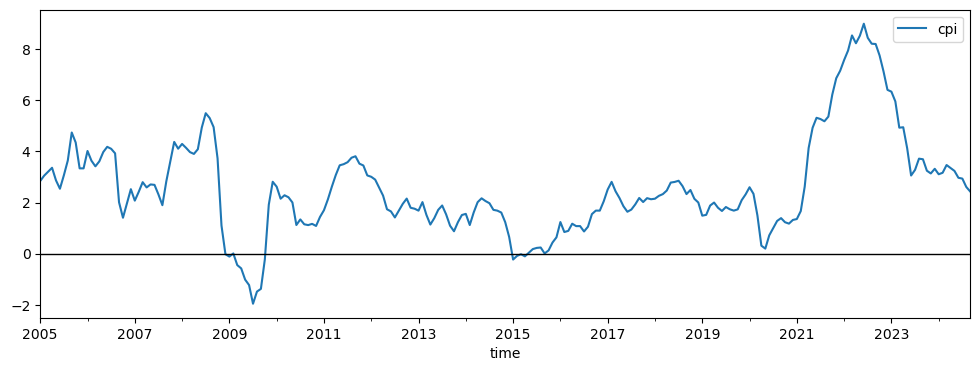

In [428]:
fig, ax = plt.subplots(figsize=(12, 4))

cpi.plot(x='time', y='cpi', ax=ax)
ax.legend()
ax.axhline(y=0, color='k', lw=1)

In [430]:
df[['loan_identifier', 'time']].head().merge(cpi, on='time', how='left')

,loan_identifier,time,cpi
0,370893910142,2005-01-01,2.844874
1,936774229300,2005-01-01,2.844874
2,936772694421,2005-01-01,2.844874
3,680743668300,2005-01-01,2.844874
4,164699402533,2005-01-01,2.844874


### House Price Index (HPI)
- All-Transactions House Price Index for the United States (USSTHPI)
- Converted YoY percentage change
- Interpolated monthly

In [509]:
hpi = (web.DataReader('USSTHPI', 'fred', start=df['time'].min() - pd.DateOffset(years=1), end=df['time'].max()+pd.DateOffset(months=1))\
      .pct_change(4) * 100).dropna()\
      .resample('MS').interpolate(method='linear')\
      .reset_index().rename(columns={'DATE':'time', 'USSTHPI':'hpi'})
hpi

,time,hpi
0,2005-01-01,11.122582
1,2005-02-01,11.398194
2,2005-03-01,11.673807
3,2005-04-01,11.949420
4,2005-05-01,11.670679
...,...,...
233,2024-06-01,5.495693
234,2024-07-01,5.211632
235,2024-08-01,5.264393
236,2024-09-01,5.317154


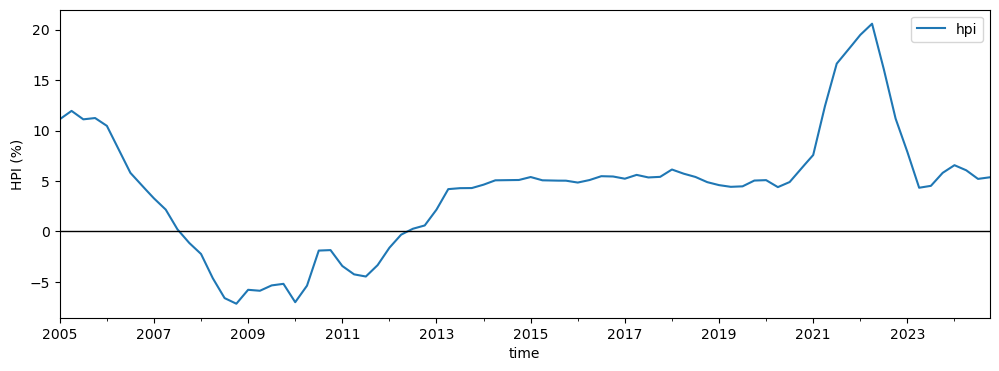

In [502]:
fig, ax = plt.subplots(figsize=(12, 4))
hpi.plot(ax=ax, x='time', y='hpi')
ax.set_ylabel('HPI (%)')
ax.axhline(y=0, color='k', lw=1)
plt.show()

In [503]:
df[['loan_identifier', 'time']].head().merge(hpi, on='time', how='left')

,loan_identifier,time,hpi
0,370893910142,2005-01-01,11.122582
1,936774229300,2005-01-01,11.122582
2,936772694421,2005-01-01,11.122582
3,680743668300,2005-01-01,11.122582
4,164699402533,2005-01-01,11.122582


In [513]:
df_macro = pd.concat([gdp.set_index('time'), 
                      unrate.set_index('time'), 
                      cpi.set_index('time'), 
                      hpi.set_index('time')], 
                     axis=1).reset_index().dropna()

df_macro

,time,gdp,unrate,cpi,hpi
0,2005-01-01,7.077140,5.3,2.844874,11.122582
1,2005-02-01,6.946700,5.4,3.053026,11.398194
2,2005-03-01,6.816260,5.2,3.206841,11.673807
3,2005-04-01,6.685820,5.2,3.361793,11.949420
4,2005-05-01,6.725435,5.1,2.869288,11.670679
...,...,...,...,...,...
232,2024-05-01,5.472413,4.0,3.238866,5.779754
233,2024-06-01,5.251997,4.1,2.970085,5.495693
234,2024-07-01,5.031580,4.2,2.938463,5.211632
235,2024-08-01,5.030279,4.2,2.610914,5.264393


<Axes: xlabel='time'>

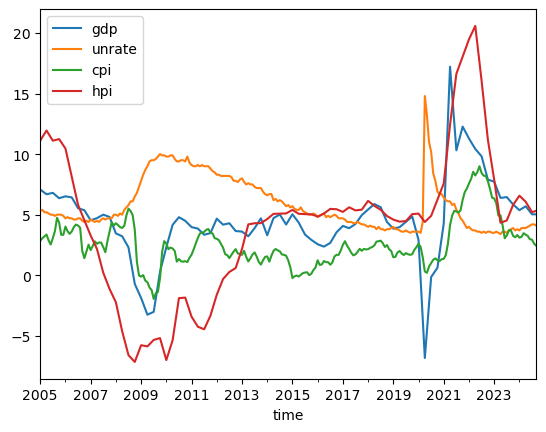

In [514]:
df_macro.set_index('time').plot()

# Define features

In [656]:
selected_variables=[
'loan_identifier',
 'time',
 # 'year',
 'channel',
 'original_interest_rate',
 'current_interest_rate',
 'original_upb',
 'current_actual_upb',
 'original_loan_term',
 'loan_age',
 'remaining_months_to_maturity',
 'original_loan_to_value_ratio_(ltv)',
 'original_combined_loan_to_value_ratio_(cltv)',
 'number_of_borrowers',
 'debt_to_income_(dti)',
 'borrower_credit_score_at_origination',
 'co_borrower_credit_score_at_origination',
 # 'first_time_home_buyer_indicator',
 'loan_purpose',
 'property_type',
 'number_of_units',
 'occupancy_status',
 'property_state',
 # 'metropolitan_statistical_area_(msa)',
 # 'zip_code_short',
 # 'mortgage_insurance_percentage',
 # 'amortization_type',
 # 'prepayment_penalty_indicator',
 # 'interest_only_loan_indicator',
 # 'interest_only_first_principal_and_interest_payment_date',
 # 'months_to_amortization',
 'delinquency_status',
 # 'zero_balance_code',
 # 'zero_balance_effective_date',
 # 'upb_at_the_time_of_removal',
 # 'total_principal_current',
 # 'last_paid_installment_date',
 # 'foreclosure_date',
 # 'special_eligibility_program',
 # 'property_valuation_method',
 # 'high_balance_loan_indicator',
 # 'borrower_assistance_plan', 
 # 'alternative_delinquency_resolution',
 # 'alternative_delinquency_resolution_count',
 'default',
 'pd_target']

In [657]:
selected_variables

['loan_identifier',
 'time',
 'channel',
 'original_interest_rate',
 'current_interest_rate',
 'original_upb',
 'current_actual_upb',
 'original_loan_term',
 'loan_age',
 'remaining_months_to_maturity',
 'original_loan_to_value_ratio_(ltv)',
 'original_combined_loan_to_value_ratio_(cltv)',
 'number_of_borrowers',
 'debt_to_income_(dti)',
 'borrower_credit_score_at_origination',
 'co_borrower_credit_score_at_origination',
 'loan_purpose',
 'property_type',
 'number_of_units',
 'occupancy_status',
 'property_state',
 'delinquency_status',
 'default',
 'target_default']

In [663]:
feature = 'loan_purpose'

print(feature, '\n')
if feature in df_missing.index:
    print(f'Missing values: {df_missing.loc[feature].freq.round(6)*100:.4f}% missing values.')
else:
    print(f'No missing values.')
print(f'Number of unique values: {df[feature].nunique()}')

loan_purpose 

No missing values.
Number of unique values: 4


In [592]:
df.loc[df[feature].isna()]['loan_identifier'].nunique()/df.loan_identifier.nunique()

2.306067923583498e-05

In [649]:
df.loc[(df[feature].isna())&(df.default == 1)]['loan_identifier'].nunique()/df.loc[df.default == 1]['loan_identifier'].nunique()

0.7701478092556748

In [ ]:
default_loans = list(df.loc[df.default == 1]['loan_identifier'].unique())
nondefault_loans = list(set(df['loan_identifier'].unique()) - set(df.loc[df.default == 1]['loan_identifier'].unique()))

In [624]:
%%time
df_nondefault_first = df.loc[df['loan_identifier'].isin(nondefault_loans)].groupby('loan_identifier').first()
df_default_first = df.loc[df['loan_identifier'].isin(default_loans)].groupby('loan_identifier').first()

CPU times: user 14.9 s, sys: 4.18 s, total: 19 s
Wall time: 21.1 s


In [650]:
df[feature].head()

0    17.0
1     NaN
2     NaN
3     NaN
4     NaN
Name: mortgage_insurance_percentage, dtype: float64

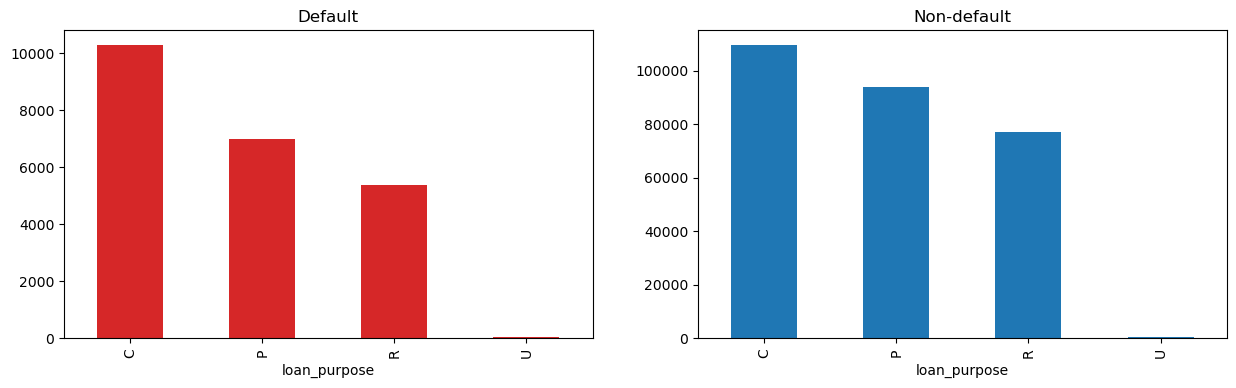

In [664]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

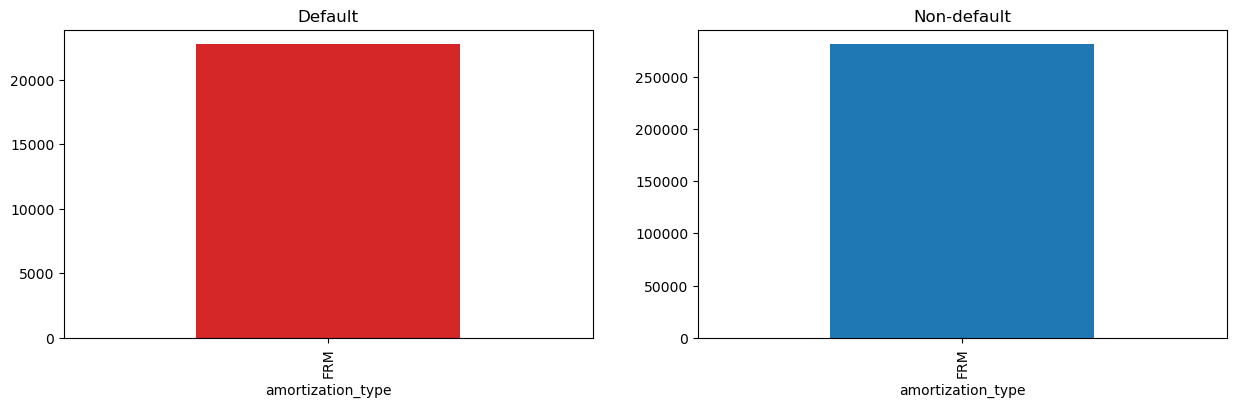

In [653]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

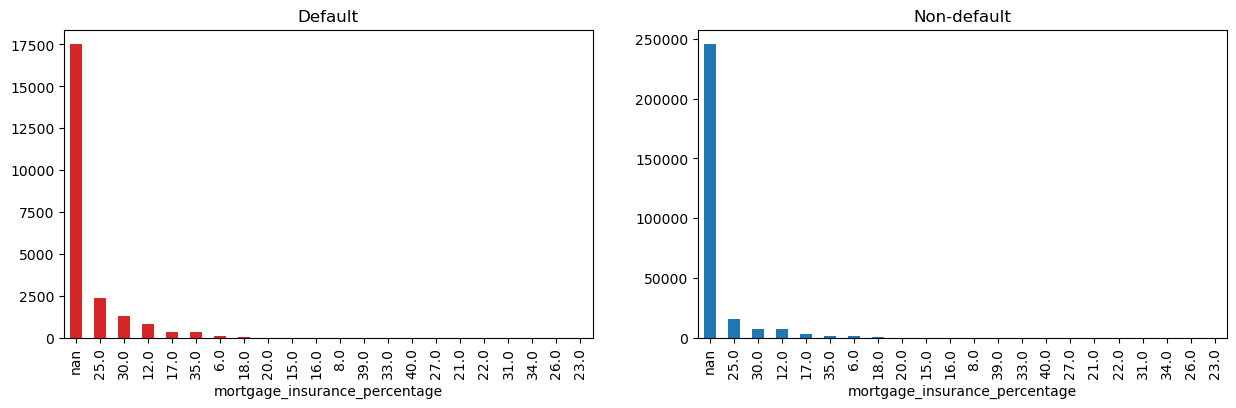

In [651]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

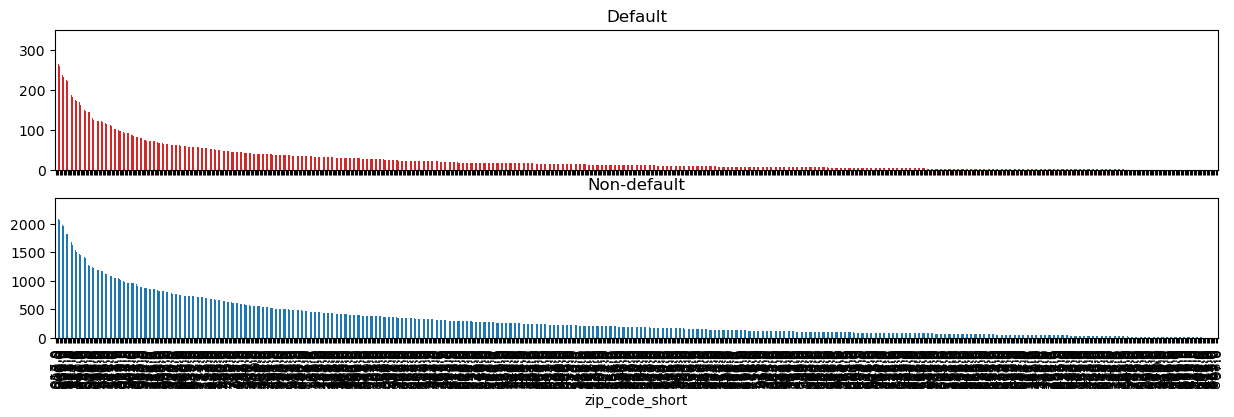

In [646]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

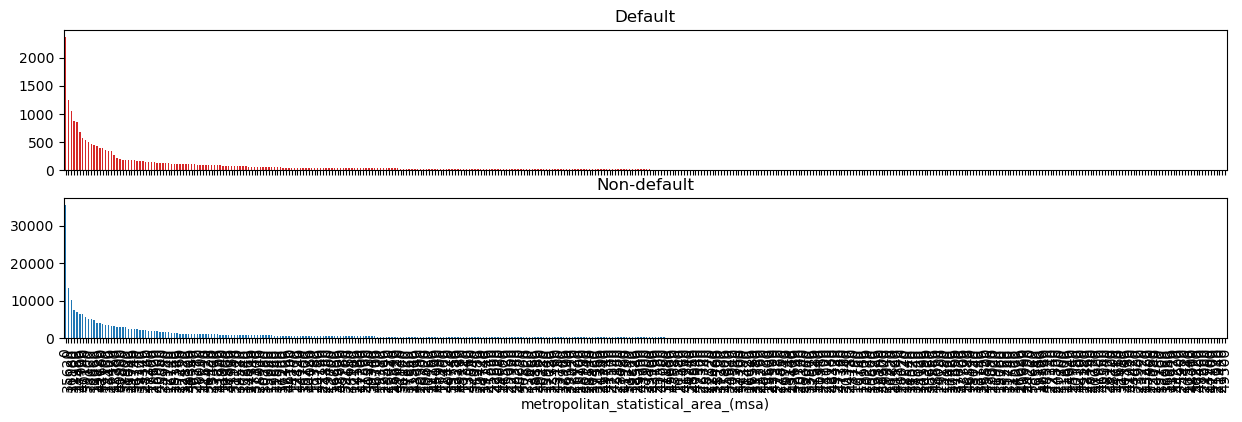

In [642]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

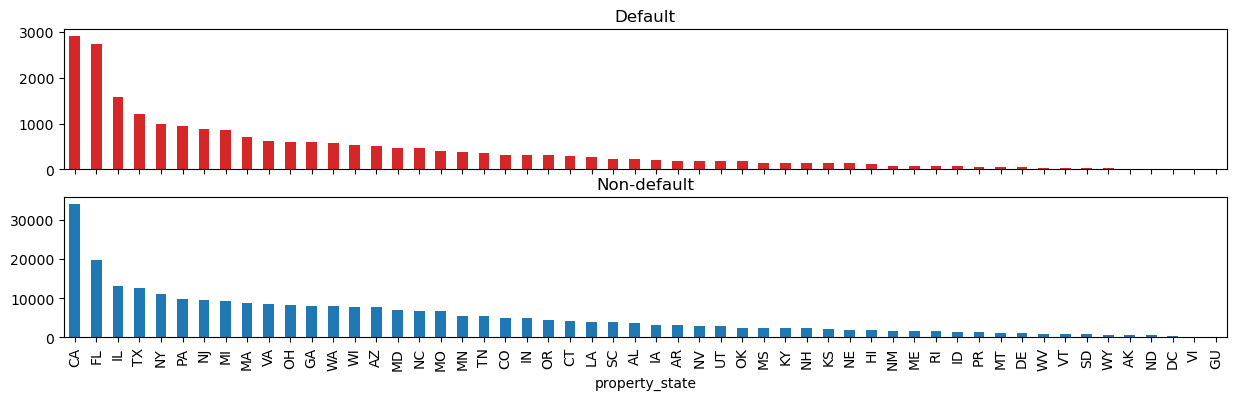

In [640]:
fig, ax = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

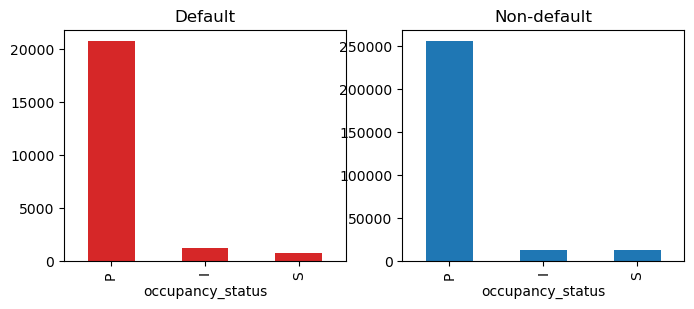

In [633]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

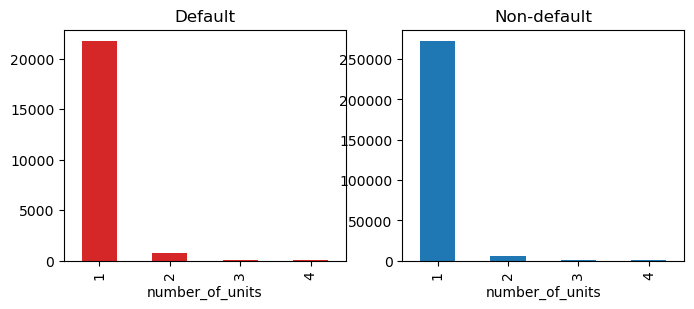

In [628]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

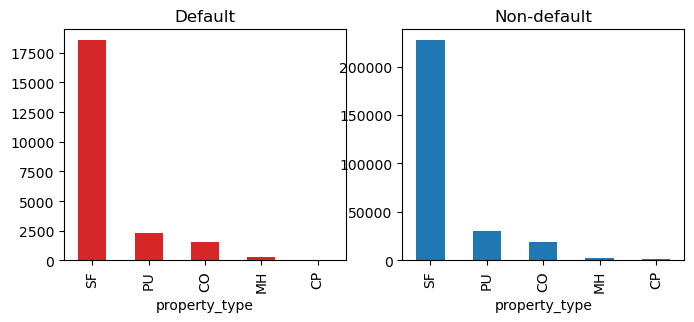

In [625]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first[feature].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

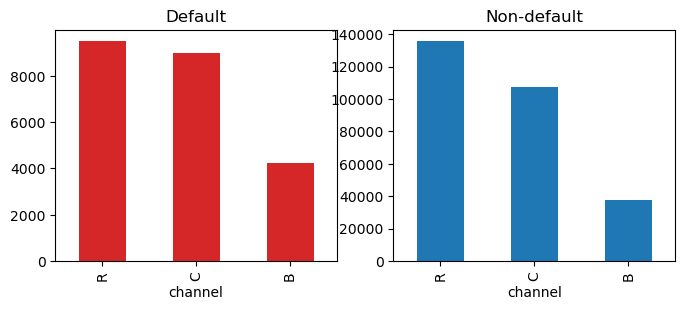

In [626]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

df_default_first['channel'].value_counts(dropna=False).plot(kind='bar', ax=ax[0], color='tab:red')
df_nondefault_first['channel'].value_counts(dropna=False).plot(kind='bar', ax=ax[1])

ax[0].set_title('Default')
ax[1].set_title('Non-default')

plt.show()

## Selected Features

In [689]:
df = df[selected_variables].copy()

KeyError: "['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination'] not in index"

In [667]:
df[df.select_dtypes(exclude=np.number).columns].nunique()

time                237
channel               3
loan_purpose          4
property_type         5
occupancy_status      3
property_state       54
dtype: int64

In [668]:
df.select_dtypes(include=np.number).columns

Index(['loan_identifier', 'original_interest_rate', 'current_interest_rate',
       'original_upb', 'current_actual_upb', 'original_loan_term', 'loan_age',
       'remaining_months_to_maturity', 'original_loan_to_value_ratio_(ltv)',
       'original_combined_loan_to_value_ratio_(cltv)', 'number_of_borrowers',
       'debt_to_income_(dti)', 'borrower_credit_score_at_origination',
       'co_borrower_credit_score_at_origination', 'number_of_units',
       'delinquency_status', 'default', 'target_default'],
      dtype='object')

# Feature Engineering

- Lag features missing
- Rolling window features missing

Notes:

debt_to_income_(dti):
- Missing values: 6.8636% missing values of all entries.
- Loan IDs: 7% missing DTI
- Defaulted Loan IDs: 8.1% missing DTI
- Number of unique values: 64
- Solution: leave nan and let XGB/LGBM handle.
  
credit_score:
- This feature is the minimum between the features ['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination']

Check property_type and number_of_units. Maybe remove one.

Check loan_purpose importance. Might be removable.

In [669]:
# Credit Score
df['credit_score'] = df[['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination']].min(axis=1)
df.drop(['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination'], axis=1, inplace=True)

/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_5992/8460081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['credit_score'] = df[['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination']].min(axis=1)
/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_5992/8460081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination'], axis=1, inplace=True)


In [667]:
df[df.select_dtypes(exclude=np.number).columns].nunique()

time                237
channel               3
loan_purpose          4
property_type         5
occupancy_status      3
property_state       54
dtype: int64

In [674]:
df[df.select_dtypes(include=np.number).columns].nunique()

loan_identifier                                   303547
original_interest_rate                               380
current_interest_rate                                413
original_upb                                         545
current_actual_upb                              12403173
original_loan_term                                   192
loan_age                                             276
remaining_months_to_maturity                         364
original_loan_to_value_ratio_(ltv)                    97
original_combined_loan_to_value_ratio_(cltv)         137
number_of_borrowers                                    7
debt_to_income_(dti)                                  64
number_of_units                                        4
delinquency_status                                    28
default                                                2
target_default                                         2
credit_score                                         407
dtype: int64

In [676]:
df[df.select_dtypes(include=np.number).columns].nunique().index.to_list()

['loan_identifier',
 'original_interest_rate',
 'current_interest_rate',
 'original_upb',
 'current_actual_upb',
 'original_loan_term',
 'loan_age',
 'remaining_months_to_maturity',
 'original_loan_to_value_ratio_(ltv)',
 'original_combined_loan_to_value_ratio_(cltv)',
 'number_of_borrowers',
 'debt_to_income_(dti)',
 'number_of_units',
 'delinquency_status',
 'default',
 'target_default',
 'credit_score']

# HERE

In [677]:
# --- Predictors

# Numerical variables
numerical_vars = ['original_interest_rate',
                  'current_interest_rate',
                  'original_upb',
                  'current_actual_upb',
                  'original_loan_term',
                  'loan_age',
                  'remaining_months_to_maturity',
                  'original_loan_to_value_ratio_(ltv)',
                  'original_combined_loan_to_value_ratio_(cltv)',
                  'debt_to_income_(dti)',
                  'delinquency_status']
# Frequency encoding variables
freq_enc_vars = []
# Target encoding variables
target_enc_vars = ['property_state']
# One-hot encoding variables
onehot_enc_vars = ['channel', 'loan_purpose', 'property_type', 'occupancy_status']
# Ordinal encoding variables
ordinal_enc_vars = ['number_of_borrowers', 'number_of_units']
# Categorical variables
cat_vars = freq_enc_vars+target_enc_vars+onehot_enc_vars+ordinal_enc_vars
# List of all predictors before encoding
var_cols = numerical_vars+cat_vars
# Geographical features for class imbalance oversampling (if used)
geo_vars = []

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# One-hot encoding
    if onehot_enc_vars:
        onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit-transform variables
        X_train_onehot = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_enc_vars].astype('str')))
        X_train_onehot.columns = onehot_encoder.get_feature_names_out()
        X_train_onehot.index = X_train.index

        X_test_onehot = pd.DataFrame(onehot_encoder.transform(X_test[onehot_enc_vars].astype('str')))
        X_test_onehot.columns = onehot_encoder.get_feature_names_out()
        X_test_onehot.index = X_test.index
        
        # Remove original categorical variables
        X_train.drop(onehot_enc_vars, axis=1, inplace=True)
        X_test.drop(onehot_enc_vars, axis=1, inplace=True)
        
        # Concatenate data set with one-hot columns
        X_train = pd.concat([X_train, X_train_onehot], axis=1)
        X_test = pd.concat([X_test, X_test_onehot], axis=1)


In [ ]:
enc = OrdinalEncoder()
enc.fit_transform(df[["number_of_units", "number_of_borrowers"]])

# main()

In [681]:
df.columns

Index(['loan_identifier', 'time', 'channel', 'original_interest_rate',
       'current_interest_rate', 'original_upb', 'current_actual_upb',
       'original_loan_term', 'loan_age', 'remaining_months_to_maturity',
       'original_loan_to_value_ratio_(ltv)',
       'original_combined_loan_to_value_ratio_(cltv)', 'number_of_borrowers',
       'debt_to_income_(dti)', 'loan_purpose', 'property_type',
       'number_of_units', 'occupancy_status', 'property_state',
       'delinquency_status', 'default', 'target_default', 'credit_score'],
      dtype='object')

In [684]:
df.rename(columns={'target_default':'pd_target'}, inplace=True)

/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_5992/3564756505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'target_default':'pd_target'}, inplace=True)


In [686]:
df.rename(columns={'pd_target':'target_default'}, inplace=True)

/var/folders/x6/nm550mg94y75s74djxxkq6kw0000gr/T/ipykernel_5992/3123351945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'pd_target':'target_default'}, inplace=True)


In [687]:
df.columns

Index(['loan_identifier', 'time', 'channel', 'original_interest_rate',
       'current_interest_rate', 'original_upb', 'current_actual_upb',
       'original_loan_term', 'loan_age', 'remaining_months_to_maturity',
       'original_loan_to_value_ratio_(ltv)',
       'original_combined_loan_to_value_ratio_(cltv)', 'number_of_borrowers',
       'debt_to_income_(dti)', 'loan_purpose', 'property_type',
       'number_of_units', 'occupancy_status', 'property_state',
       'delinquency_status', 'default', 'target_default', 'credit_score'],
      dtype='object')

In [682]:
# Split data into Train/Test sets
X, y = df[var_cols], df['pd_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

KeyError: 'pd_target'

In [1524]:
print(f'Class imbalance before: {100*y_train.sum()/len(y_train):.3f}%')

Class imbalance before: 3.514%


# Model

Features:

- Credit score
- Income
- Demographics/Geography (aggregate features)


Macroeconomics

- GDP
- Unemployment rate
- Interest rates
- 

<font size=5> Archive </font>

In [332]:
# # GDP
# def load_BEA_GDP(path, filename, to_monthly_method=None):
#     gdp = pd.read_csv(path+filename, skiprows=3)
#     gdp.drop('Line', axis=1, inplace=True)
#     gdp.rename(columns={'Unnamed: 1': 'Measure'}, inplace=True)
#     gdp.loc[0, 'Measure'] = 'quarter'
#     gdp = gdp.T
#     gdp.columns = gdp.iloc[0].to_list()
#     gdp.drop(gdp.index[0], inplace=True)
#     gdp.reset_index(inplace=True)
#     gdp.rename(columns={'index':'year', '        Gross domestic product':'gdp_quarter'}, inplace=True)
#     gdp.insert(0, 'time', gdp['year'].str[:4]+gdp['quarter'])
#     gdp['gdp_quarter'] = gdp['gdp_quarter'].astype(float)
#     gdp['time'] = pd.PeriodIndex(gdp['time'], freq='Q').to_timestamp()
#     gdp = gdp[['time', 'gdp_quarter']]
    
#     if to_monthly_method == 'repeat':
#         return gdp.set_index('time').resample('MS').ffill().rename(columns={'gdp_quarter':'gdp'}).reset_index()
#     elif to_monthly_method == 'interpolate':
#         return gdp.set_index('time').resample('MS').interpolate(method="linear").rename(columns={'gdp_quarter':'gdp'}).reset_index()
#     else:
#         return gdp.rename(columns={'gdp_quarter':'gdp'})

# gdp = load_BEA_GDP(DATA_PATH+'macro/', 'BEA_GDP_2005_to_2024.csv', to_monthly_method='interpolate')